# MNIST Digit Classification with TensorFlow

Richard Corrado <richcorrado@gmail.com> April 2017

For the Fat Cat Fab Lab Machine Learning Meetup

An introduction to the MNIST digit database and the classification problem using Random Forests can be found in the notebook MNIST_Digits-overview.ipynb at <https://github.com/richcorrado/MNIST-digits>. A readable html version is at <https://richcorrado.github.io/MNIST_Digits-overview.html>.   

In this notebook, we'll be using TensorFlow to apply neural networks to the MNIST digits. In particular, we'll learn:

1. How to use scikit-learn to perform a one-hot encoding of ordinal class labels, suitable for "one vs all" multiclass classification.

2. How to use scikit-learn functions to standardize features, including the case where we want to preserve some sparsity of features.

3. What the TensorFlow Computational Graph framework is and what classes are introduced by TensorFlow to implement it.

4. How to build a TensorFlow Session by organizing TensorFlow classes to specify the graph, parameters, cost function, optimizer.

5. How to run the TensorFlow session to train the model, compute metrics and make predictions.

Along the way, we'll 

* Implement Logistic Regression in TensorFlow.

* Understand Feedforward Neural Networks as generalization of Linear Models and how to use them for classification.

* Understand dropout regularization of NNs.

* Understand the basics of Convolutional and Max Pooling NN layers and why they're useful. 

* Examine the examples that have been misclassified and explore some reasons for that.

N.B. This notebook should run in 8GB of RAM.  If you have less than that, or are otherwise having memory problems, adjust the code for the convolutional neural network to compute less features.  

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.precision',5)
pd.set_option('display.max_colwidth',100)

import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from matplotlib import pyplot
rcParams['figure.figsize'] = 12, 4
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from time import time
import scipy

In the overview notebook, we used the data from the kaggle playground site.  In this notebook, we will use the full MNIST data from the csvs at https://pjreddie.com/projects/mnist-in-csv/. These files can be obtained there or as `mnist_train.csv` and `mnist_test.csv` from the input subdirectory of the github containing this file. These files do not have a header row, so we create column names.

In [2]:
column_names = ['label']

for i in range(0,784):
    column_names.append("pixel" + str(i))
    
train_df = pd.read_csv("./input/mnist_train.csv", header=None, names=column_names)
test_df = pd.read_csv("./input/mnist_test.csv", header=None, names=column_names)

There are a few reasons for changing the dataset.  One, the overview notebook was designed to give more of an overview of machine learning practices.  It made sense to introduce the reader to kaggle as another tool for learning.  However, in this notebook, we're going to be studying some neural networks, which typically benefit from  increasing the number of training examples.  So it is better to study the complete MNIST training data and test against the benchmark test set instead of creating a separate validation set and decreasing the training set further. 

N.B. The reader is encouraged to create a separate training/validation set from the official train set for, e.g. optimizing hyperparameters.  On a fast computer, it might be better to use cross-validation over the official train set for this.

The data consist of handwritten digits that have been processed by recording the greyscale intensity of a 28x28 array of pixels. These pixel intensity matrices have been unrolled into a vector of 784 features.  Details are in the overview notebook.  Here we provide a function to reshape the pixel vector into a 28x28 matrix and another function to plot the digits corresponding to a specified list of row indices.

In [3]:
# recover the 28x28 matrix from a row of train_df
def pixel_mat(row, df=train_df):
    # we're working with train_df so we want to drop the label column
    vec = df.drop('label', axis=1).iloc[row].values
    # numpy provides the reshape() function to reorganize arrays into 
    # specified shapes
    pixel_mat = vec.reshape(28,28)
    return pixel_mat


def plot_digits(list_input, df=train_df):
    # generate a 4xn grid of subplots, 4 is the number of columns that will 
    # reasonably display in typical
    # overhead projector resolution at the size we're making the images 
    list_len = len(list_input)
    ncols = 4
    nrows =  (list_len / 4) + (1 * (list_len % 4 != 0)) # add an extra row 
                                                        # if list_len !div by 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))


    # axs is a 2d array so we flatten it into a vector in order to loop over it
    for i, ax in enumerate(axs.reshape(-1)):
        if i < list_len:   # don't generate ax titles for unused subplots
            # Title is digit label, which can be found by referencing the label 
            # column of the row specified by rand_idx[i]
            ax.set_title("Digit Label: %d" % df['label'].iloc[list_input[i]])
            # pixel_mat(rand_idx[i]) is the pixel matrix. 
            # The imshow flags are the ones that are used in the matshow wrapper
            ax.imshow(pixel_mat(list_input[i], df=df), cmap=plt.cm.gray, 
                      origin='upper', interpolation='nearest')
            ax.axis('off')
    # tight_layout gives more spacing between subplots    
    plt.tight_layout()   
    # Tell matplotlib to draw all of the previously generated objects
    plt.show()

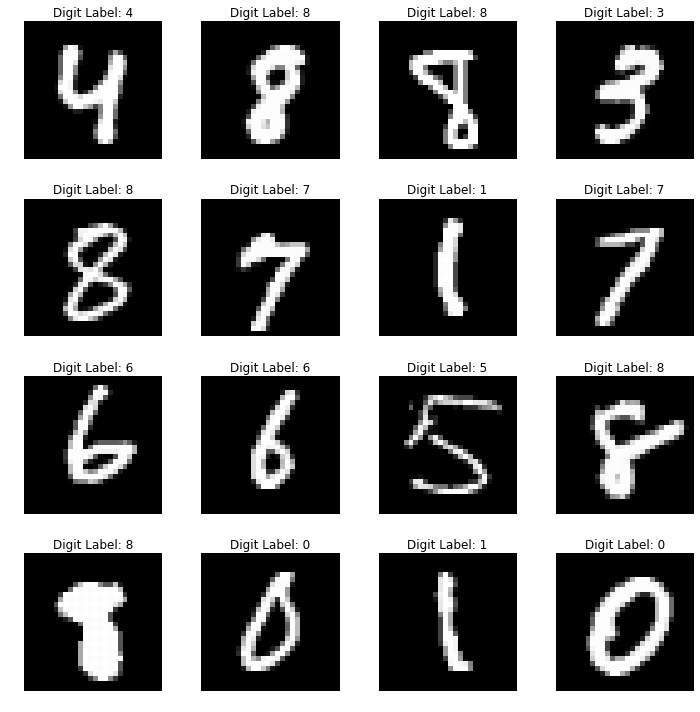

In [4]:
# generate a list of 16 random rows which are our digits
rand_idx = np.random.choice(train_df.index, size=16, replace=False)
plot_digits(rand_idx)

We generate design matrices and response vectors directly from the dataframes

In [5]:
x_train = train_df.drop(['label'], axis=1).values
print(x_train.shape)
y_train = train_df['label'].values
print(y_train.shape)

x_test = test_df.drop(['label'], axis=1).values
print(x_test.shape)
y_test = test_df['label'].values
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


## Random Forest Benchmarks

In the overview notebook, we applied random forests in scikit-learn to the digit classification problem.  Here we will reproduce those results on the larger dataset in order to establish a baseline for the neural network models we'll study shortly.

In [6]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs=-1, random_state = 32)

We will determine appropriate hyperparameters using 10-fold cross-validation using the StratifiedKFold function that preserves class frequencies in the splits.

In [7]:
kfold = StratifiedKFold(n_splits=10, random_state=7)

Furthermore, we will use a random search scheme, since, in the overview notebook, that gave excellent results in much less time than grid search. We will use a similar parameter distribution

In [8]:
rf_param =  {'n_estimators': scipy.stats.randint(150,400), 
             'max_depth': scipy.stats.randint(12,28), 
             'max_features': scipy.stats.randint(15,40)}

from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(rf_clf, param_distributions=rf_param, 
                        scoring = 'accuracy', n_jobs=-1, 
                        n_iter=30, cv=kfold) 

Twenty iterations of cross-validation over the entire dataset would take a huge amount of time, so we will create a 10% split into a tuning set, using StratifiedShuffleSplit to preserve class frequencies.   This is a crutch that one must often rely when dealing with larger datasets.  We hope that an optimal set of parameters for a sample of our dataset is close to the optimal set of parameters for the entire dataset.   

In [9]:
tuning_split = StratifiedShuffleSplit(n_splits=1, train_size=0.10, random_state=96)
tune_idx = list(tuning_split.split(x_train, y_train))[0][0]

x_tune = x_train[tune_idx]
y_tune = y_train[tune_idx]

In [10]:
%time rs.fit(x_tune, y_tune)

CPU times: user 24.7 s, sys: 526 ms, total: 25.2 s
Wall time: 9min 37s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=7, shuffle=False),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=32,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=30, n_jobs=-1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4db0594490>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4db0594750>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f4db05946d0>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

This finds a best candidate in around 10 minutes.   Random search over the entire dataset would take around 1.5 hours.

We can return the best estimator :

In [11]:
rf_clf_rs = rs.best_estimator_ 
rf_clf_rs

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=22, max_features=29, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=394, n_jobs=-1, oob_score=False, random_state=32,
            verbose=0, warm_start=False)

Then fit the full training data and predict on the test set:

In [12]:
rf_clf_rs.fit(x_train, y_train)
y_rf_pred = rf_clf_rs.predict(x_test)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_rf_pred)

0.97160000000000002

This is on par with the result in the overview notebook.  The extra 0.5% of accuracy can be explained by the increase in the size of the training data (see the learning curve computed in that notebook). 

## One-hot Encoding of the Class Labels

In this dataset, the class labels are encoded as integers 0-9.  This posed no difficulty in our random forest benchmark, as many scikit-learn classification models are designed to properly treat the multiclass problem using this type of encoding.  However, TensorFlow (TF) is designed to allow very low-level design of models. Therefore, it is necessary to provide the framework to treat multiclass classification as part of the TF computation graph.   

In preparation for this, we will encode the class labels as 10d vectors rather than as integers,

$$ \begin{split} 
& 0 \longrightarrow ( 1, 0, \ldots,  0), \\
& 1 \longrightarrow (0, 1, 0, \cdots,  0), \\
& \ldots,  \\
& 9\longrightarrow ( 0, 0, \cdots,  0,1) \end{split}$$
  
This is sometimes called "one hot" encoding, since the presence of a defining class is indicated by a binary 1 in a vector and is analogous to the implementation of binary logic in circuits.  In the context of classification, this scheme is called "one vs all" classification and is fairly easy to implement  as an additional layer of our model in TF.  In scikit-learn, one vs all is already build into the multiclassification models so that the end user does not have to perform this additional step.

N.B. If you have already seen one hot encoding of categorical features, you might notice that our encoding here is a reducible representation of the class labels.  That is, we have 10 class labels and we could actually encode them using 9 bits by assigning one of the classes to the 0....0 representative. Such an irreducible representation is preferred for the levels of a categorical feature, but not for a class label.  This is because, if we use the reducible representation here, we can easily apply an argmax function to an output vector to determine the class.  If we had used the irreducible representation, we'd need an extra step to map an output vector matching 0...0 to the last class.  This is an unnecessary complication, so we just use the reducible representation.

To accomplish this encoding easily, we can use the OneHotEncoder or LabelBinarizer from scikit-learn. Since we are dealing with class labels, we will use LabelBinarizer.  This uses the fit, then predict/transform, methods common to the scikit-learn functions.

In [14]:
from sklearn.preprocessing import LabelBinarizer

In [15]:
lb = LabelBinarizer()

In [16]:
lb.fit(y_train)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

We can see explictly how the labels are transformed by applying the transformation to:

In [17]:
range(10)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

whose elements are mapped to 

In [18]:
lb.transform(range(10))

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

which can be compared to the equations written above.

We apply the transformation to all of our response vectors:

In [19]:
y_train_oh = lb.transform(y_train)
y_test_oh = lb.transform(y_test)

## Standardizing the Data

We'll be using neural networks in this notebook.  Since the connections between layers of a neural network are made via linear models (with weights as slopes and biases as intercepts) and the weights are typically determined through some version of gradient descent, we will want to standardize our data in some way. 

Let's briefly see why we'd want to do this in a case where we have two features $x_1, x_2$ and a response $y$. Suppose also that we are using the residual sum of squares as our cost function.  So our learning algorithm will be attempting to minimize

$$ J(w,b) = \sum | w_1 x_1 + w_2 x_2 + b - y |^2,$$

where the sum is over the rows of our training data. In gradient descent, which is typically used as part of a backpropagation algorithm, we will be computing the derivatives

$$ \frac{\partial J}{\partial w_i} = 2 \sum x_i (w_1 x_1 + w_2 x_2 + b - y).$$

If the range of $x_1$ and $x_2$ are very different, then the corresponding derivatives will also range over very different values, owing to the factor of $x_i$.  For example, if our model was about house prices, $x_1$ could be the living area, with typical value 2000 sq ft, while $x_2$ is the number of bedrooms, which might be 2 or 3 in most cases.

In this example $\partial J/\partial x_1$ will typically be 1000 times as large as $\partial J/\partial x_2$  and this might, in the best case, mean that gradient descent takes much longer to converge.  In a more complicated example, in the worst case, since activation functions destroy convexivity, gradient descent might get stuck at a poor local minimum.

For these reasons, it is a good practice to standardize the features in some way so that their range of variation is similar.  There are various ways of doing this.  For example, in statistics when we say that variables have been standardized, we usually mean the z-score,

$$ z = \frac{x - \mu}{\sigma},$$

where $\mu$ and $\sigma$ are the mean and standard deviation, respectively, over the measured values of $x$.  This has the obvious advantages that the mean of the new variable $\bar{z} = 0$ and standard deviation $\sigma_z = 1$.  In scikit-learn, the function for applying this transformation is found in the preprocessing kit and called <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">StandardScaler</a>.

Another type of standardization is to scale the data to a given range, by using the max and min values of the unscaled data. We can first scale to the range $[0,1]$ via

$$ x_\text{std} = \frac{ x - x_\text{min} }{ x_\text{max} - x_\text{min} }, $$

then to the range $[a,b]$ via

$$ x_\text{scaled} = \frac{ x_\text{std} }{b -a  } + a. $$

The scikit-learn function for this is <a href ="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html">MinMaxScaler</a>.

We can also rescale data to the range $[-1,1]$ by dividing by the maximal absolute value in the unscaled data,

$$ x_\text{scaled} = \frac{ x }{ \text{max}( |x_\text{min}|,|x_\text{max}|)} $$

This transformation has the advantage that sparse data remains sparse, i.e., if $x=0$, then $x_\text{scaled} =0$.  By contrast, the z-score sends values $x = 0$ to $z=-\mu$, destroying sparsity. The scikit-learn function for this is <a href ="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html">MaxAbsScaler</a>.

The MNIST data is relatively sparse, since 80% of the pixels are blank, so it is a good idea to use a rescaling that preserves the sparseness.  Since the pixel intensities are always nonnegative, it really doesn't matter whether we use MinMaxScaler or MaxAbsScaler, but we'll use MaxAbsScaler to emphasize that it preserves sparsity in the general case.

In [20]:
from sklearn.preprocessing import MaxAbsScaler

The proper way to use these scaling functions is to fit them on just the training data, then separately transform the training and validation sets.  This is so that we don't introduce any bias in the training data by using properties of our validation data.  First we assign an object to the function,

In [21]:
training_scaler = MaxAbsScaler()

We fit this to x_training,

In [22]:
training_scaler.fit(x_train)

MaxAbsScaler(copy=True)

Then transform the associated data sets.

In [23]:
x_train_scaled = training_scaler.transform(x_train)
x_test_scaled = training_scaler.transform(x_test)

We can compare the nonzero values of the scaled data to the unscaled data to see how this worked:

In [24]:
x_train_scaled[np.where(x_train_scaled != 0)]

array([ 0.01176471,  0.07058824,  0.07058824, ...,  0.75686275,
        0.77254902,  0.5254902 ])

In [25]:
x_train[np.where(x_train != 0)]

array([  3,  18,  18, ..., 193, 197, 134])

N.B. The MNIST data is actually standardized to the interval [0,255].  However, a general real-world dataset that you encounter will not be, so we made sure to cover the best practice in this notebook.

## TensorFlow

There is already a tutorial about using TensorFlow to study MNIST at <https://www.tensorflow.org/get_started/mnist/pros> and we will follow that to some extent, fleshing many details out and adding explanations.   If you haven't installed tensorflow, be sure and do so using the instructions for your OS at <https://www.tensorflow.org/install/>.

TensorFlow (TF) uses a <a herf="https://www.tensorflow.org/get_started/get_started#the_computational_graph">**Computational Graph**</a> model of defining computations.  We can think of each operation as a node of a graph, which is similar to how we organize a neural network. It is worthwhile to describe the detail of a computational graph, since understanding the structure is very important in successful construction of new models.

When using scikit-learn models, we most likely only have to deal with the data in the form of a design matrix and, for training data, a response vector (or matrix in multivariate or possibly multiclass problems).   The user can ignore many details of how the model functions transform the data and implement the particular machine learning algorithms.  However, since TF is intended to be a much lower-level framework for constructing models, it allows that inputs or intermediate expressions can be tensors of any shape.  

In order to handle this,  TF includes a new class called **Tensor** that is used to pass numpy arrays of any shape from one Operation to another. We can think of these as the lines in the graph. In TF an **Operation** is a class that performs a computation on Tensors.  Operations (also called ops) are the nodes of the graph. TF operations include very simple arithmetic like addition tf.add(a, b) or multiplication tf.matmul(a, b), for tensors a, b. Operations also include neural net activation functions and convolution and pooling operations.

In order to specify model parameters, such as weights and biases, TF provides the constructor class **Variable()**. In terms of the computational graph, calling Variable() actually adds two ops. The first is an assign op that assigns the initial value that you specify for the variable, while the second is an op that holds the value of the variable,  which can be changed during learning rounds.

In addition to the computational graph, TF is also based on a mechanism of Feeding data and variables into the computational graph.  In order to facilitate this, TF provides a class called **Placeholder** that can be used to pass a design matrix or hyperparameter into the appropriate operation of the graph.  For instance, the input and output layers of a neural network will be specified by placeholders of the appropriate shape.  Hyperparameters such as learning rates or hidden layer widths can also be specified by placeholders.   The **feed dictionary** has the format ```feed_dict = {placeholder1: array1, placeholder2: array2, ...}```, where placeholder# is the name assigned to the placeholder and array# is a numpy array (can also be a single number when appropriate).

The mechanics of using TF is the following: 

1. We define a TF instance or session using the class Session() or, for notebooks, InteractiveSession(), e.g., sess = tf.InteractiveSession()

2. We specify the computational graph using the necessary Placeholders, Variables and Operations.

3. We define functions of the graph outputs, like the cost function.  TF will treat these as tensor class objects.

4. We specify an optimizer, typically using the method .minimize(cost_function). For example, optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

5. Training is accomplished using the .run method on the session. For example, we might run sess.run([optimizer, cost], feed_dict=feed_dict).   This feeds the values of all placeholders using a python dictionary named feed_dict, accomplishing feedforward computation of the cost function and backpropagation using the specified optimizer. We can iterate the sess.run method for as many training epochs as needed.

6. Validation can be accomplished by executing sess.run while feeding in the validation data to the input placeholders. In addition to the cost function, we can evaluate other metrics by defining the appropriate function and specifying it in sess.run.

7. Prediction is also accomplished via sess.run, now using the new data and specifying the output variable or an appropriate function thereof.

A visualization of a training session is:

![TF training session](tf_session.png)

A complication of the TF methodology is that during design of the computational graph, it is not too easy to remove or redefine parts of the graph that we've already defined. If we want to change an earlier step of the graph, it can be simplest to just delete the old graph with the command tf.reset_default_graph() and start over.

## Logistic Regression

It is best to illustrate the mechanics of TF with a simple model.  Therefore we will implement logistic regression, which requires specifying the computational graph, cost function, optimizer, etc., but doesn't require introducing neural network technology.  After understanding the TF application here, we will introduce various types of neural network layers and the TF implementation of them.

While we're not exactly defining a neural network yet, we will still use the terminology of layers to describe the computational graph for the logistic regression model.  This is both because the layer structure is built in to the TF design and also because, as we'll see later, logistic regression is, in fact, a very simple form of neural network.  Neural networks should actually be thought of as a framework for generalizing and combining other type of ML models, though combination and composition of simple functions.

We will begin by importing TensorFlow and starting an interactive session.

In [26]:
import tensorflow as tf
sess = tf.InteractiveSession()

# set random seed
tf.set_random_seed(464)

The first part of the computational graph will generally be the specification of an **input layer**.  The purpose of the input layer is to provide a data structure into which we'll feed our design matrix when we run the session.

We know that we have 784 features/columns in our design matrix.  However, we have training and validation sets with different number of examples/rows.  TF allows us to introduce placeholder variables with size None to facilitate feeding data sets of different sizes into the same computational graph:

In [27]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])

We'll also specify a placeholder for our target labels. We transformed these to one-hot 10d vectors.

In [28]:
n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

Recall that logistic regression applies a linear model

$$ \mathbf{z} = \mathbf{X W }+ \mathbf{b}$$

to compute a linear output $\mathbf{z}$ of shape (# of examples) X (# of classes), which we can call the logits.  The next step is to apply the softmax function to obtain the model class probabilities:

$$ p_{i, c} = \text{softmax}(z_i)_c = \frac{\exp (z_{i,c})}{\sum_{c'} \exp (z_{i,c'})}.$$

Finally, we can make actual class predictions by setting $\hat{y_i}=c$, for $c$ corresponding to the largest computed probability, using an appropriate argmax function in practice.

To implement this in TF, we specify a layer to compute the linear model above.  We have to specify the weights $\mathbf{W}$, which correspond to a tensor of shape [n_feat, n_class] and the biases, which are a vector of shape [n_class].  We use the Variable() class to define both with zero initial values:

In [29]:
W = tf.Variable(tf.zeros([n_feat, n_class]))
b = tf.Variable(tf.zeros([n_class]))

tf.zeros is the TF version of numpy zeros that creates a TF Tensor rather than a numpy array data structure. 

To complete the definition of the layer, we specify the linear model for the logits:

In [30]:
z_out = tf.add(tf.matmul(x, W), b)

We use the TF function matmul to multiply Tensors and add to add them.  We could also have used "+", since TF overloads that operator to properly handle Tensor objects.  The object z_out defined by this statement is created as a Tensor and cast into the shape and data type appropriate from the operation:

In [31]:
z_out

<tf.Tensor 'Add:0' shape=(?, 10) dtype=float32>

We can call this layer, the **output layer**, since it returns an array that is in 1-1 correspondence with the model prediction. At this point, we could apply the softmax function to obtain the class probabilities and then define a **cost function** using the cross-entropy.  However, since this is a very common step, TF includes a version of the cross-entropy function that accepts the logits as inputs:

In [32]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=z_out))

The function tf.nn.softmax_cross_entropy_with_logits is essentially

$$ J_i = \sum_c y_{ic} \ln \text{softmax}(\mathbf{z}_i)_c, $$

which can be considered as a 1d tensor of shape [# of examples]. We can verify this explicitly by calling:

In [33]:
tf.nn.softmax_cross_entropy_with_logits(labels=y_true, 
                                        logits=z_out)

<tf.Tensor 'Reshape_5:0' shape=(?,) dtype=float32>

The role of the tf.reduce_mean function is to compute the average cost per example fed into the computational graph.  

In addition to the cost function, we can define appropriate **metrics** to be computed when we run the TF session. In this case, we can compute the accuracy score by the two step expression:

In [34]:
corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

In the first line, we use the TF argmax function to compute both the most probable class and the true class, and then define a 1d tensor with entry True whenever the predicted class is equal to the true class.  Note that the argmax is applied directly to the logit for efficiency.  The fact that the softmax function is monotonically increasing means that the order of the logits on the real line is the same as the order of the probabilities.   

In the second line, we recast our boolean vector to a numerical one and apply reduce_mean to compute the accuracy score. 

Next, we have to specify an **optimizer** operation, which we'll choose to be simple gradient descent.

In [35]:
learning_rate = 0.01
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

We have chosen a learning rate that should be appropriate for the standardized features we're using here.  By calling the .minimize method on cost, this op will: 

* compute cost via feedforward of the computational graph
* compute derivatives with respect to the variables upon which cost depends
* apply the derivatives in backpropagation to update the variables and reduce the cost function

Full training via gradient descent is obtained by looping the optimizer call over an appropriate number of training epochs.

Next, we will develop our strategy for **feeding data** into computational graph.  With a very large dataset, the combined feedforward and backpropagation operations would require an enormous amount of memory to store computational results.  It is therefore standard practice to run training steps on different **mini-batches** of the training data at each iteration.  For a mini-batch size of around 100 training examples, a relatively modest amount of memory is required to store the network parameters and various derivatives needed for backprop. 

Mini-batch processing will only work well if we make enough iterations to both cycle through the full training data and make enough additional passes so that each example is seen an appropriate number of times to allow gradient descent to converge.   The term **training epoch** is used to denote the number of iterations necessary to feed the entire training data through at least one feedforward/backprop cycle.  We then have to train over a sufficient number of epochs to allow convergence.

To get a handle on this, let's look at the size of our training set:

In [36]:
n_samp = x_train_scaled.shape[0]
n_samp

60000

With a minibatch size of 50, we can compute the number of minibatches to cycle over in an epoch:

In [37]:
n_batch = 50.
total_batch = int(n_samp / n_batch)
total_batch

1200

We want to construct a scheme where we split the training data into 1200 unique minibatches, so that we see every training example exactly once in a minimum number of passes.  We expect that the scheme will work best if the minibatches are both randomized and have approximately the same distribution of classes as the training set itself.  We can accomplish this using StratifiedKFold, where we use the "test" partition in each fold as the minibatch. 

Note:  TF also includes the function tf.train.shuffle_batch to implement batch processing.  It doesn't allow for stratifying class labels, but is an option to consider.

An appropriate implementation of StratifiedKFold is:

In [38]:
skfold = StratifiedKFold(n_splits=total_batch, shuffle=True, random_state=428)

We are finally ready to define the full training scheme:

In [39]:
# Number of epochs to train over. Should be large enough for convergence.  
# If it is too large, at worst the model
# might overfit, at best we waste computing time.
n_epoch = 200

# In order to monitor training progress, as well as tune n_epoch, 
# we will computing appropriate 
# metrics at checkpoints
display_step = 25

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()
for epoch in range(n_epoch):
    # init average cost 
    avg_cost = 0.
    
    # skfold.split(x,y) returns a list of pairs of index arrays
    # of the form (train indices, test indices)
    # minibatch indices are the test indices, labeled batch_idx here.
    # the training indices are not used, we just assign them to dummy_idx
    # fold is the number of the fold in range(total_batch)
    # One loop over the folds is a single epoch.
    # Note also that we use the ordinal class labels in y_training 
    # because StratifiedKFold wouldn't work with the
    # one-hot encoding
    for dummy_idx, batch_idx in skfold.split(x_train_scaled, y_train):
        # extract design matrix and response array for minibatch
        # here we can use the one-hot response array
        x_batch, y_batch = x_train_scaled[batch_idx], y_train_oh[batch_idx]
        # run backprop and feedforward
        # we assign the cost per example to c
        # Note the feed_dict contains the minibatch data
        _, c = sess.run([optimizer, cost], feed_dict={x: x_batch, y_true: y_batch})
        # Compute average cost
        avg_cost += c / total_batch
        
    # Display logs per epoch step
    if epoch % display_step == 0:
        # return epoch and average cost
        print("Epoch: %.4d" % epoch, "cost = %.4f" % avg_cost, 
              "time = %.2f" % (time() - start))
        # compute accuracy on full training set
        train_acc = sess.run(accr, 
                             feed_dict={x: x_train_scaled, y_true: y_train_oh})
        print ("TRAIN ACCURACY: %.3f" % (train_acc))
        # compute accuracy on full validation set
        test_acc = sess.run(accr, 
                            feed_dict={x: x_test_scaled, y_true: y_test_oh})
        print ("TEST ACCURACY: %.3f" % (test_acc))

# After the full training cycle, return more logs
train_acc = sess.run(accr, 
                     feed_dict={x: x_train_scaled, y_true: y_train_oh})      
test_acc = sess.run(accr, 
                    feed_dict={x: x_test_scaled, y_true: y_test_oh})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print ("TRAIN ACCURACY: %.3f" % (train_acc))
print ("TEST ACCURACY: %.3f" % (test_acc))   

('Epoch: 0000', 'cost = 0.8942', 'time = 5.74')
TRAIN ACCURACY: 0.865
TEST ACCURACY: 0.873
('Epoch: 0025', 'cost = 0.2994', 'time = 147.56')
TRAIN ACCURACY: 0.917
TEST ACCURACY: 0.919
('Epoch: 0050', 'cost = 0.2798', 'time = 288.10')
TRAIN ACCURACY: 0.922
TEST ACCURACY: 0.922
('Epoch: 0075', 'cost = 0.2706', 'time = 428.84')
TRAIN ACCURACY: 0.925
TEST ACCURACY: 0.923
('Epoch: 0100', 'cost = 0.2648', 'time = 570.30')
TRAIN ACCURACY: 0.927
TEST ACCURACY: 0.923
('Epoch: 0125', 'cost = 0.2607', 'time = 711.36')
TRAIN ACCURACY: 0.928
TEST ACCURACY: 0.924
('Epoch: 0150', 'cost = 0.2575', 'time = 851.77')
TRAIN ACCURACY: 0.929
TEST ACCURACY: 0.924
('Epoch: 0175', 'cost = 0.2550', 'time = 992.53')
TRAIN ACCURACY: 0.930
TEST ACCURACY: 0.925
Optimization finished in 1130.42 seconds!
TRAIN ACCURACY: 0.931
TEST ACCURACY: 0.925


It appears that we would get slightly more accuracy by increasing the training epochs.  However, at 92.5% accuracy, we are far behind our Random Forest result of 97%, so it's clear that no amount of extra training is going to make logistic regression competitive.  For that we will move on to neural networks in the next section.

Before moving on, we close the TF session.

In [40]:
sess.close()

## Single Hidden Layer Neural Network

We'll start with the simplest type of neural network, which is a fully-connected single hidden layer. This is the simplest of a class of models called feedforward neural networks or multilayer perceptrons (MLP).

We'll introduce the structure of a neural network by expanding upon that of the logistic regression model we just discussed.  That model could be understood in terms of: 

1. An input layer, whose role was to feed the input design matrix into the model.  
2. An output layer, consisting of a linear transformation of the input features into the logits which were in 1-1 correspondence with the model response, namely the class labels.

The nontrivial part of the model was assigned to the output layer, where the input features were transformed into the class labels.    We can understand this to a prototype for how to interpret a more general layer of a neural network.  Each layer takes as input some features and then applies some mathematical function to them to generate some new features as output.  In a typical case, our function will be a composition of a linear function, depending on some weights and biases,
$$ \mathbf{z^{(i)}} = \mathbf{f}^{(i-1)} \mathbf{W}^{(i)} + \mathbf{b}^{(i)},$$
and another function, possibly nonlinear, called the activation function:
$$ \mathbf{f}^{(i)} = g^{(i)}(\mathbf{z}^{(i)}).$$
These are called the **hidden layers** because their associated output features are hidden as composites of the actual function computed by the complete network:
$$ \mathbf{y} = F(\mathbf{x}) = f^{(M)} \circ \cdots \circ f^{(1)}(\mathbf{x}).$$

A graphical depiction of a neural network with a single hidden layer is:

![single hidden layer network](single_layer.png)

In this picture, we've drawn each feature as a node of the graph. The lines indicate which old features are involved in the definition of each new feature. In the figure, at the left, we have an input layer that takes $F$ input features.  The hidden layer has a width $n$ and computes $n$ new features.  The lines show that the input features are fully connected to the nodes of the hidden layer.  This means that the weights and biases at the hidden layer
$$ z^{(1)} = X W^{(1)} + b^{(1)}$$
are full and of shape

* $W^{(1)}$: [# of input features, width]
* $b^{(1)}$: [# of examples, width]

We can also choose an **activation** function at the hidden layer.  The role of the activation function is to introduce some nonlinearity in the function that the complete network will learn.  In this notebook, we will always use the **Rectified Linear Unit, or ReLU**, activation function, defined by:
$$ g(z) = \text{max}(0,z) = \begin{cases} z, & z \geq 0 \\ 0, & z < 0. \end{cases}$$
A plot of ReLU is:

![ReLU function](relu.png)

We can say that the features computed by the hidden layer are 
$$ f^{(1)} = g\left( X W^{(1)} + b^{(1)}\right) .$$

Finally, the output layer introduces another set of weights and biases to compute the output logits:
$$ z_\text{out} = f^{(1)} W + b.$$
As in the case of our logistic regression model, it is not strictly necessary to explicitly apply the softmax function for many of the computations in TensorFlow.  In the case where we do, we can refer to the output layer as a "softmax layer", since the softmax function is taking the role of an activation function.   In this notebook, we won't apply softmax as part of the computational graph.

#### Dropout Regularization

In machine learning, one must be continuously vigilant against the competing problems of **underfitting** and **overfitting**.   Underfitting typically occurs because the model is too simplistic and doesn't allow enough variation to fit the trend described by the training data.  This is also called the **bias** problem, because the hypothesis function $y = f(x)$ typically represents an erroneous assumption about the relationship between the response and the features.  Overfitting occurs when the model is too complex relative to the training data.  It can therefore be possible to achieve a very low training error, but the resulting model fails to generalize well to new data: the validation or test error will be relatively large compared to the training error.  This is also called the **variance** problem, since small changes to the training data will tend to lead to large changes in the learned model.

Neural networks can be susceptible to both problems, but the problem of overfitting is potentially more common.  Overfitting will generally occur in a generalized linear model when the number of parameters in the hypothesis function is relatively large compared to the amount of information in the training data.  Neural networks with many large hidden layers can overfit if there is not a comparably large and diverse training set.

Regularization is a collection of techniques that are designed to reduce the test error, usually at the expense of a modest increase in the training error.  A common form of regularization, especially in generalized linear models, is **parameter norm regularization**, also known as **weight decay**.  This type of regularization works by shifting the cost function by a term that depends on a suitable norm function of the parameters:
$$ \begin{split} 
& \tilde{J}(\mathbf{W};\mathbf{x},\mathbf{y}) = J(\mathbf{W};\mathbf{x},\mathbf{y})  + \Omega(\mathbf{W}), \\
& \Omega(\mathbf{W})= \begin{cases}
\frac{\alpha}{2} (\mathbf{W}^T \mathbf{W} ), & L^2, \text{(Ridge regression)}, \\
\alpha \sum_i | W_i |, & L^1,  \text{(LASSO)}. \end{cases} \end{split}$$

Weight decay provides an additional penalty in optimization that depends on the size of the parameters.  For appropriate choice of the hyperparameter $\alpha$, optimization of the new cost will then favor solutions where relatively unimportant parameters take very small values and the important parameters will control the fit to the general trend contained in the training data.  Without weight decay, the unimportant parameters could be tuned at will to drive the fit closer to the training data points and away from the generalized trend of the true sample population.

Weight decay is a suitable regularization technique for neural networks, but we want to introduce another form of regularization called **dropout**.   Dropout is related to another approach to the variance problem called **bootstrap aggregation** or **bagging**.  Bagging is an **ensemble** method where the predictions of many models are used to make a single prediction, either by averaging, majority vote or some other criterion.   While any single model may be prone to overfit, the ensemble prediction is expected to be closer to the "true" value.  Statistically, the quality of the ensemble is controlled by how independent the individual models are from one another.

To explain dropout, consider our single hidden layer model.  The width of the hidden layer is a hyperparameter and we would consider models of different widths to be different models.  These models might not be completely independent, since after training, the weights might end up taking similar values.  This is very much to be expected if some input features are highly correlated with certain output responses.

In any case, we can start with a wide hidden layer and simulate the models with a smaller hidden layer by multiplying some of the weights by a factor of 0.  The result of doing this one at a time looks like:

![effect of dropout on a single layer](dropout.png)

More specifically, when implementing dropout, we'll assign a number $\rho_i$ to each node that is the probability that we keep the output of that node during the training cycle.  Each training cycle then trains a different model, but all of the models are built from a different subset of a large collection of shared parameters. Therefore the submodels are not very independent of one another, but the difference here is that we can sample a fairly large ensemble of models for a very small computational cost. 

To complete the ensemble prediction we use another estimation rule called the **weight scaling inference rule**.  This says that we can approximate the ensemble probability distribution $p_\text{ens.}(y|x)$ by evaluating $p(y|x)$ in the model with all units, but with the weights going out of the unit $i$ multiplied by the probability $\rho_i$ of including $i$. A typical choice is $\rho_i = 1/2$.

#### Back to TensorFlow

Let us build this single hidden layer neural network in TensorFlow. We will start by clearing the previous graph and starting a new interactive session.

In [41]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# set random seed
tf.set_random_seed(464)

Our input and output are defined exactly as before:

In [42]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])

n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

Next, we have to specify the weights for the (first) hidden layer. As explained above, this is a tensor of dimension [n_feat, width], where width is the number of nodes in the hidden layer. 

It's a good idea to set up some functions to initialize our weights to some small random values. This is because if initialized all of the weights to be zero, then during feedforward, all of the outputs will be the same, as well as the derivatives during backprop.  Each weight will be updated by the same amount and we're unlikely to generate any asymmetry in the weights and the network is unlikely to succeed in learning anything useful. 

In fact, we'll just import these from the tutuorial we linked to earlier, since they do exactly what we need.

In [43]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

These draw the initial weights from a positively truncated normal distribution and set the biases to a small positive constant.  Having a positive bias tends to result in good performance when using ReLU activation functions, which we will do below.

We will start with a hidden layer with 784 nodes, fully connected to the input layer. We choose this value because it is equal to the number of input features and it will make it easier to compare the output features with the input features.  

In general, there is no good rule about how many features we need in the hidden layer for a neural network to perform well.  One can make guesses by looking at what worked well on similar problems, but the best practice is to test many different sizes using (cross-)validation until a nearly optimal size is found.   

In [44]:
width1 = 784
W_1 = weight_variable([n_feat, width1])

We also want to define the same bias for each node.  

In [45]:
b_1 = bias_variable([width1])

At the nodes, we'll apply ReLU, via:

In [46]:
h_1 = tf.nn.relu(tf.add(tf.matmul(x, W_1), b_1))

Note that we again used the tf.matmul and tf.add functions.

Next, we'll introduce a dropout application as a regularization of the model.  As in the tutorial, we'll introduce a placeholder for the probability to keep the output during dropout.  This way we can use dropout during training, but turn it off easily when we run our predictions on the validation set.

In [47]:
keep_prob = tf.placeholder(tf.float32)
h_1_drop = tf.nn.dropout(h_1, keep_prob)

Finally, the output layer will produce a vector for our 10 possible digit classes.  We introduce more weights and biases, now with the size [width1, n_class]:

In [48]:
W_out = weight_variable([width1, n_class])
b_out = bias_variable([n_class])

z_out = tf.add(tf.matmul(h_1_drop, W_out), b_out)

Once again, we don't apply any activation function at the output layer (this is "linear activation").  We'll use the same TF function to compute the cross-entropy directly from the logits. If we need to later, we can apply argmax  to get the most probable label, or the softmax function to obtain the probabilities for all of the classes.  We will also use the same accuracy score metric as in the logistic regression example.

In [49]:
cost = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=y_true, 
                                                logits=z_out))
corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

Next, we have to define an optimizer. In this case, we should note that the GradientDescentOptimizer that we used before took a long time to converge, and we might not have even trained long enough for it to completely converge.  Therefore, we'll choose to use the AdamOptimizer this time.  Adam is a form of gradient descent that uses several techniques to adapt the updates based on the rates at which the cost function and it's derivatives are changing.  It is expected to have faster convergence at the cost of additional computational overhead for each step. 

In [50]:
learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

We will train the model by slightly modifying the previous training code to include the dropout hyperparameter.

In [51]:
# Number of epochs to train over.
n_epoch = 140 + 1

# We will compute appropriate metrics at checkpoints
display_step = 15

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()
for epoch in range(n_epoch):
    # init average cost 
    avg_cost = 0.
    
    # minibatch indices are the test indices, labeled batch_idx here.
    # the training indices are not used, we just assign them to dummy_idx
    # fold is the number of the fold in range(total_batch)
    # One loop over the folds is a single epoch.
    for dummy_idx, batch_idx in skfold.split(x_train_scaled, y_train):
        # extract design matrix and response array for minibatch
        # here we can use the one-hot response array
        x_batch, y_batch = x_train_scaled[batch_idx], y_train_oh[batch_idx]
        # run backprop and feedforward
        # we assign the cost per example to c
        # Note the feed_dict contains the minibatch data
        _, c = sess.run([optimizer, cost], 
                        feed_dict={x: x_batch, y_true: y_batch, keep_prob: 0.5})
        # Compute average cost
        avg_cost += c / total_batch
        
    # Display logs per epoch step
    if epoch % display_step == 0:
        # return epoch and average cost
        print("Epoch: %.4d" % epoch, "cost = %.4f" % avg_cost, 
              "time = %.2f" % (time() - start))
        # compute accuracy on full training set
        train_acc = sess.run(accr, 
                             feed_dict={x: x_train_scaled, 
                                        y_true: y_train_oh, 
                                        keep_prob: 1.})
        print ("TRAIN ACCURACY: %.4f" % (train_acc))
        # compute accuracy on full validation set
        test_acc = sess.run(accr, 
                            feed_dict={x: x_test_scaled, 
                                       y_true: y_test_oh, 
                                       keep_prob: 1.})
        print ("TEST ACCURACY: %.4f" % (test_acc))

# After the full training cycle, return more logs
train_acc = sess.run(accr, feed_dict={x: x_train_scaled, 
                                      y_true: y_train_oh, 
                                      keep_prob: 1.})      
test_acc = sess.run(accr, feed_dict={x: x_test_scaled, 
                                     y_true: y_test_oh, 
                                     keep_prob: 1.})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print ("TRAIN ACCURACY: %.4f" % (train_acc))
print ("TEST ACCURACY: %.4f" % (test_acc))   

('Epoch: 0000', 'cost = 0.7490', 'time = 14.42')
TRAIN ACCURACY: 0.9206
TEST ACCURACY: 0.9244
('Epoch: 0015', 'cost = 0.0621', 'time = 237.35')
TRAIN ACCURACY: 0.9906
TEST ACCURACY: 0.9791
('Epoch: 0030', 'cost = 0.0289', 'time = 459.47')
TRAIN ACCURACY: 0.9982
TEST ACCURACY: 0.9833
('Epoch: 0045', 'cost = 0.0148', 'time = 676.07')
TRAIN ACCURACY: 0.9995
TEST ACCURACY: 0.9833
('Epoch: 0060', 'cost = 0.0095', 'time = 900.91')
TRAIN ACCURACY: 1.0000
TEST ACCURACY: 0.9842
('Epoch: 0075', 'cost = 0.0061', 'time = 1125.31')
TRAIN ACCURACY: 1.0000
TEST ACCURACY: 0.9851
('Epoch: 0090', 'cost = 0.0047', 'time = 1352.38')
TRAIN ACCURACY: 1.0000
TEST ACCURACY: 0.9846
('Epoch: 0105', 'cost = 0.0039', 'time = 1576.17')
TRAIN ACCURACY: 1.0000
TEST ACCURACY: 0.9852
('Epoch: 0120', 'cost = 0.0030', 'time = 1795.55')
TRAIN ACCURACY: 1.0000
TEST ACCURACY: 0.9861
('Epoch: 0135', 'cost = 0.0027', 'time = 2020.37')
TRAIN ACCURACY: 1.0000
TEST ACCURACY: 0.9859
Optimization finished in 2100.41 seconds!
TRAI

At a bit better than 98.6% accuracy, this model is a 1.6% improvement in accuracy over our Random Forest result of 97%.  Each training epoch has taken around 15s, for a total training time of a little more than one-half hour.

It might be possible to improve the results of this model by adjusting the parameters.  The width of the hidden layer, the learning rate, the minibatch size, etc. (even the choice of activation functions!) should all be viewed as hyperparameters that should be tuned to improve the accuracy of the model.  In future discussions, we will investigate some effects of hyperparameter tuning in neural networks.  Some issues to be concerned about:

1. Width and depth of the network determines the **capacity** of the network, in information-theory terms.  Counting independent weight and bias parameters leads to some number $P$ of independent coefficients that must be optimized during training.  If the training data has $N$ examples and $F$ features, then we can think of $NF$ as an upper bound on the number of coefficients we can determine.   Since features can be interdependent or correlated, and examples can overlap, the actual bound $B \leq NF$ is highly dependent on the data.   
    * If $B < P$, then the system is underdetermined.  In such a case, **overfitting** is a serious concern and regularization, techniques, like dropout, become very important.
    * If $B \gg P$, then the model might not have enough capacity to generalize well.  An obvious exception can be when there is a very strong feature with a simple relationship to the response (linear, power law, etc.).  Then a simple model might be strongly predictive. 
    * Adjusting the width and/or depth of the network and examining (cross-)validation error can help to find an optimum capacity for the model.

2. The learning rate controls the step size in parameter space used during gradient descent. 
    * If the learning rate is too large, we will overshoot the minimum of the cost function.  Gradient descent might not converge, since the cost function will never be optimized according to whatever tolerance parameter or metric we are considering.
    * If the learning rate is too small, the training might take a longer time than necessary, consuming time and other resources we could have used more efficiently.
    * If the learning rate is too small, we could end up in a local minimum and the step we make in parameter space is not large enough to get us out.
    
3. If the minibatch size is too small, the corresponding step during gradient descent will also be relatively small. We might get stuck in a local minimum.

4. If the number of training cycles is too small, then we will not have used the training data to maximum effectiveness.  If the number of training cycles is too large, we either waste time or allow the model to overfit.  As a regularization technique, putting a limit on the number of training cycles is called **early stopping**.

For now, we'll look at adding an additional hidden layer to see how that affects the accuracy. 

Let's save the class probabilities predicted by this model:

In [52]:
class_prob_singlayer = sess.run(tf.nn.softmax(z_out), 
                          feed_dict={x: x_test_scaled, 
                                     y_true: y_test_oh, 
                                     keep_prob: 1.})

We can also compute the features produced by the hidden layer.  Let's do this for a sample of 1s from the training set.

In [53]:
np.random.seed(253)

# get all indices from y_train where the label is 1
ones_idx = np.where(y_train == 1)[0]

# pick 10 entries at random
rand_ones_idx = np.random.choice(ones_idx, 5)

# corresponding design matrix from scaled features
x_train_ones = x_train_scaled[rand_ones_idx]
y_train_ones = y_train_oh[rand_ones_idx]

h1_train_ones = sess.run(h_1, feed_dict={x: x_train_ones, 
                                         y_true: y_train_ones,
                                         keep_prob: 1.})

Now we will plot the original features on the left and the hidden layer features on the right: 

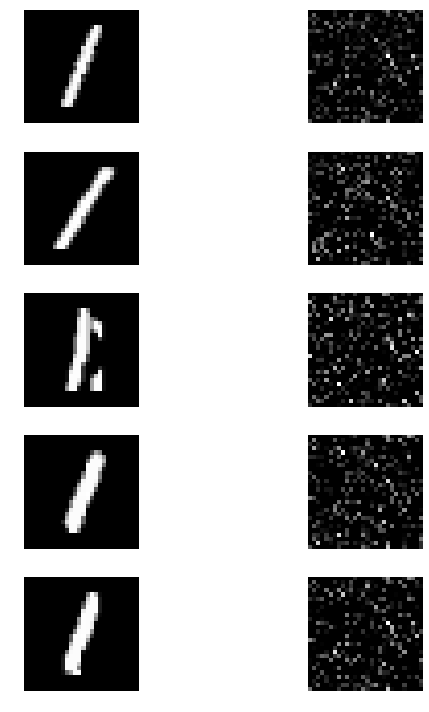

In [54]:
fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

for i, ax in enumerate(axs.reshape(-1)):
    if (i % 2 == 0):   # even axes are the original features
        pixel_mat_in = x_train_ones[i/2].reshape(28,28)
        ax.imshow(pixel_mat_in, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.axis('off')
    if ((i-1) % 2 == 0):   # odd axes are the hidden layer features
        pixel_mat_hl = h1_train_ones[(i-1)/2].reshape(28,28)
        ax.imshow(pixel_mat_hl, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.axis('off')
# tight_layout gives more spacing between subplots    
plt.tight_layout()   
# Tell matplotlib to draw all of the previously generated objects
plt.show()

We can repeat this for images of 2s:

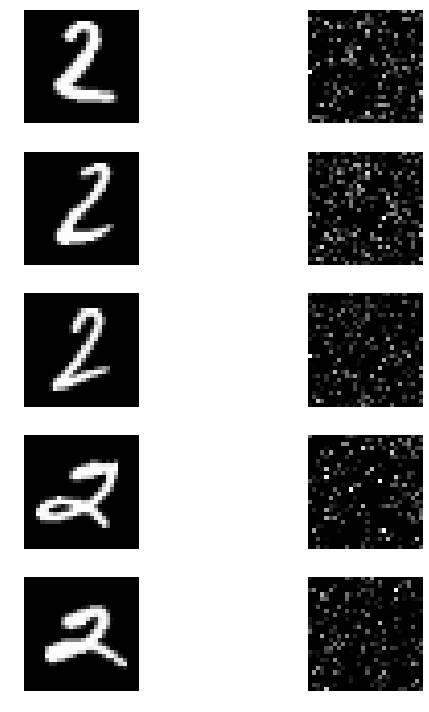

In [55]:
# get all indices from y_train where the label is 2
twos_idx = np.where(y_train == 2)[0]

# pick 10 entries at random
rand_twos_idx = np.random.choice(twos_idx, 5)

# corresponding design matrix from scaled features
x_train_twos = x_train_scaled[rand_twos_idx]
y_train_twos = y_train_oh[rand_twos_idx]

h1_train_twos = sess.run(h_1, feed_dict={x: x_train_twos, 
                                         y_true: y_train_twos,
                                         keep_prob: 1.})

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10,10))

for i, ax in enumerate(axs.reshape(-1)):
    if (i % 2 == 0):   # even axes are the original features
        pixel_mat_in = x_train_twos[i/2].reshape(28,28)
        ax.imshow(pixel_mat_in, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.axis('off')
    if ((i-1) % 2 == 0):   # odd axes are the hidden layer features
        pixel_mat_hl = h1_train_twos[(i-1)/2].reshape(28,28)
        ax.imshow(pixel_mat_hl, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.axis('off')
# tight_layout gives more spacing between subplots    
plt.tight_layout()   
# Tell matplotlib to draw all of the previously generated objects
plt.show()

We can take the sums of the matrices above and plot the aggregate features for the 1s (in greyscale vs the 2s (in bluescale):

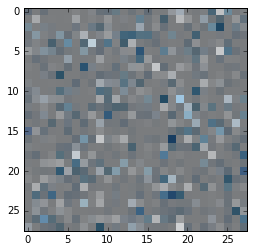

In [56]:
ones_sum_mat = h1_train_ones.sum(0).reshape(28,28)
twos_sum_mat = h1_train_twos.sum(0).reshape(28,28)

plt.figure(1)
plt.imshow(ones_sum_mat, cmap=plt.cm.gray, origin='upper', interpolation='nearest')
plt.imshow(twos_sum_mat-1, cmap=plt.cm.Blues, origin='upper', interpolation='nearest', alpha=0.5)
   
plt.show()

The highlights don't seem to have very much overlap, but there isn't any particular geometric order.  This is because the hidden layer was fully-connected and didn't preserve much information about how the original images were organized (at least in the vertical direction.)

Finally, we can aggregate data from 100 of each digit:

In [57]:
h1_sum = []

for dig in range(10):
    idxs = np.where(y_train == dig)[0]
    rand_idxs = np.random.choice(idxs, 100)

    h1_sum.append(sess.run(h_1, feed_dict={x: x_train_scaled[rand_idxs],
                                           y_true: y_train_oh[rand_idxs],
                                           keep_prob: 1.}
                          ).sum(0).reshape(28,28)
                   )
h1_sum = np.array(h1_sum)

# normalize to [0,1]
for i in range(10):
    h1_sum[i] = h1_sum[i] / np.amax(h1_sum[i])
    
h1_sum.shape

(10, 28, 28)

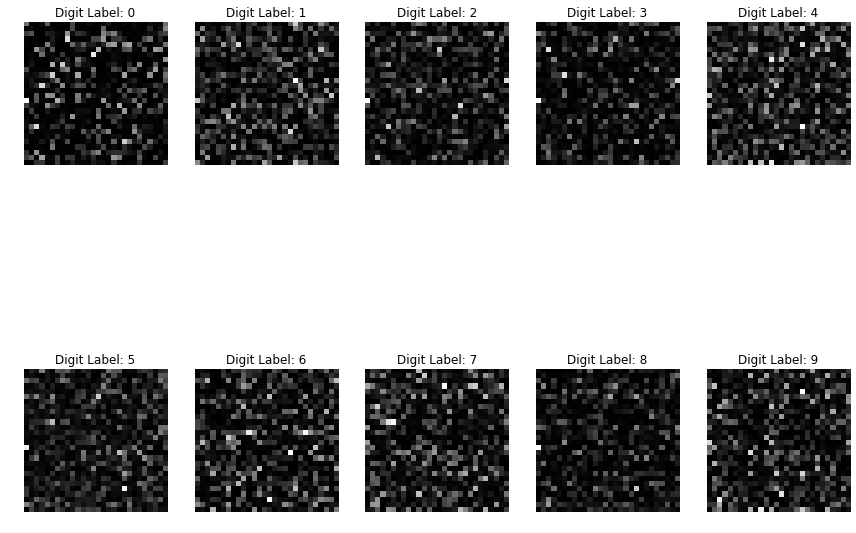

In [58]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12,12))

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_title("Digit Label: %d" % i)
    ax.imshow(h1_sum[i], cmap=plt.cm.gray, 
              origin='upper', interpolation='nearest')
    ax.axis('off')
# tight_layout gives more spacing between subplots    
plt.tight_layout()   
# Tell matplotlib to draw all of the previously generated objects
plt.show()

It's clear that there is substantial variation between the hot spots for different digits, but se can't distinguish the digits from these features by eye.  I found there was considerable overlap when I tried to plot these on the same axes using a colormap, so that the result wasn't very descriptive.

Let's close the session and add a second hidden layer.

In [59]:
sess.close()

## Multilayer Perceptron

We will quickly execute a two-layer perceptron here and then move on to more complicated (and deep) networks.  The command reset_default_graph will reset the graph so that we can start fresh.

In [60]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# set random seed
tf.set_random_seed(464)

In [61]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])
n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

width1 = 784 
W_1 = weight_variable([n_feat, width1])
b_1 = bias_variable([width1])
h_1 = tf.nn.relu(tf.add(tf.matmul(x, W_1), b_1))

keep_prob = tf.placeholder(tf.float32)
h_1_drop = tf.nn.dropout(h_1, keep_prob)

width2 = 784 
W_2 = weight_variable([width1, width2])
b_2 = bias_variable([width2])
h_2 = tf.nn.relu(tf.add(tf.matmul(h_1_drop, W_2), b_2))

h_2_drop = tf.nn.dropout(h_2, keep_prob)

W_out = weight_variable([width2, n_class])
b_out = bias_variable([n_class])

z_out = tf.add(tf.matmul(h_2_drop, W_out), b_out)

cost = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(labels=y_true, 
                                                    logits=z_out))

learning_rate = 0.0005
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

The hidden layer sizes were chosen in order that the training runs in a reasonably short amount of time.

In [62]:
# Number of epochs to train over. 
n_epoch = 190 + 1

# Compute appropriate metrics at checkpoints
display_step = 20

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()
for epoch in range(n_epoch):
    # init average cost 
    avg_cost = 0.
    

    for dummy_idx, batch_idx in skfold.split(x_train_scaled, y_train):
        x_batch, y_batch = x_train_scaled[batch_idx], y_train_oh[batch_idx]
        _, c = sess.run([optimizer, cost], 
                        feed_dict={x: x_batch, 
                                   y_true: y_batch, 
                                   keep_prob: 0.5})
        # Compute average cost
        avg_cost += c / total_batch
        
    # Display logs per epoch step
    if epoch % display_step == 0:
        # return epoch and average cost
        print("Epoch: %.4d" % epoch, "cost = %.4f" % avg_cost, 
              "time = %.2f" % (time() - start))
        # compute accuracy on full training set
        train_acc = sess.run(accr, 
                             feed_dict={x: x_train_scaled, 
                                        y_true: y_train_oh, 
                                        keep_prob: 1.})
        print ("TRAIN ACCURACY: %.4f" % (train_acc))
        # compute accuracy on full validation set
        test_acc = sess.run(accr, 
                            feed_dict={x: x_test_scaled, 
                                       y_true: y_test_oh, 
                                       keep_prob: 1.})
        print ("TEST ACCURACY: %.4f" % (test_acc))

# After the full training cycle, return more logs
train_acc = sess.run(accr, 
                     feed_dict={x: x_train_scaled, 
                                y_true: y_train_oh, 
                                keep_prob: 1.})      
test_acc = sess.run(accr, 
                    feed_dict={x: x_test_scaled, 
                               y_true: y_test_oh, 
                               keep_prob: 1.})
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print("For width1 = %d, width2 = %d, n_epoch = %d," \
      % (width1, width2, n_epoch))
print ("TRAIN ACCURACY: %.4f" % (train_acc))
print ("TEST ACCURACY: %.4f" % (test_acc))        

('Epoch: 0000', 'cost = 0.6190', 'time = 19.94')
TRAIN ACCURACY: 0.9560
TEST ACCURACY: 0.9547
('Epoch: 0020', 'cost = 0.0400', 'time = 440.34')
TRAIN ACCURACY: 0.9972
TEST ACCURACY: 0.9832
('Epoch: 0040', 'cost = 0.0271', 'time = 862.08')
TRAIN ACCURACY: 0.9993
TEST ACCURACY: 0.9859
('Epoch: 0060', 'cost = 0.0213', 'time = 1308.06')
TRAIN ACCURACY: 0.9995
TEST ACCURACY: 0.9850
('Epoch: 0080', 'cost = 0.0229', 'time = 1764.39')
TRAIN ACCURACY: 0.9998
TEST ACCURACY: 0.9847
('Epoch: 0100', 'cost = 0.0192', 'time = 2230.44')
TRAIN ACCURACY: 0.9999
TEST ACCURACY: 0.9855
('Epoch: 0120', 'cost = 0.0211', 'time = 2707.46')
TRAIN ACCURACY: 0.9999
TEST ACCURACY: 0.9857
('Epoch: 0140', 'cost = 0.0180', 'time = 3182.79')
TRAIN ACCURACY: 0.9999
TEST ACCURACY: 0.9852
('Epoch: 0160', 'cost = 0.0157', 'time = 3710.24')
TRAIN ACCURACY: 0.9999
TEST ACCURACY: 0.9863
('Epoch: 0180', 'cost = 0.0180', 'time = 4225.29')
TRAIN ACCURACY: 1.0000
TEST ACCURACY: 0.9868
Optimization finished in 4488.99 seconds!
Fo

At 98.7% test accuracy, this model is only slightly better than the result of our single layer model. This model also takes about twice as long to train. 

Again, it is possible that better tunings would improve the result. For instance, at 80 and several later epochs, the cost function has increased, indicating that adjustments to the learning rate should be tested.  

In [63]:
class_prob_twolayer = sess.run(tf.nn.softmax(z_out), 
                          feed_dict={x: x_test_scaled, y_true: y_test_oh, keep_prob: 1.})

We can also visualize the features produced at each hidden layer.

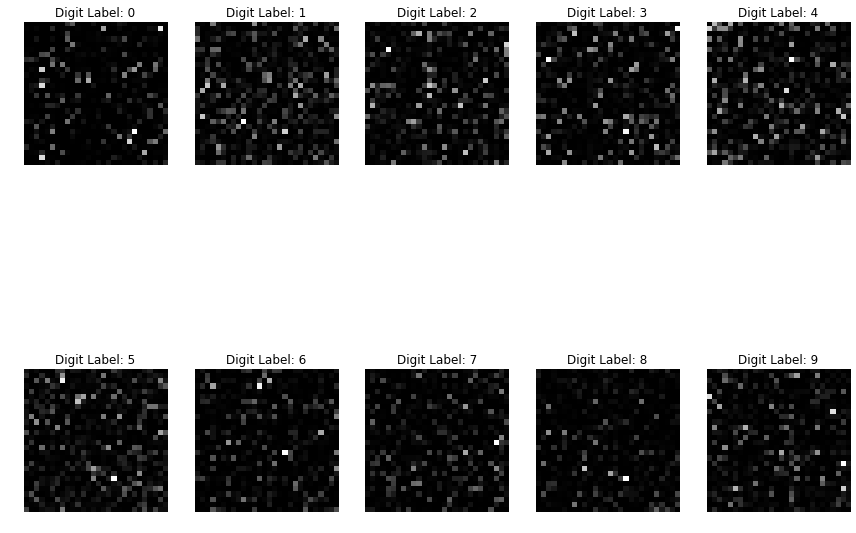

In [64]:
h1_sum = []

for dig in range(10):
    idxs = np.where(y_train == dig)[0]
    rand_idxs = np.random.choice(idxs, 100)

    h1_sum.append(sess.run(h_1, feed_dict={x: x_train_scaled[rand_idxs],
                                           y_true: y_train_oh[rand_idxs],
                                           keep_prob: 1.}
                          ).sum(0).reshape(28,28)
                   )
h1_sum = np.array(h1_sum)

# normalize to [0,1]
for i in range(10):
    h1_sum[i] = h1_sum[i] / np.amax(h1_sum[i])
    
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12,12))

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_title("Digit Label: %d" % i)
    ax.imshow(h1_sum[i], cmap=plt.cm.gray, 
              origin='upper', interpolation='nearest')
    ax.axis('off')
# tight_layout gives more spacing between subplots    
plt.tight_layout()   
# Tell matplotlib to draw all of the previously generated objects
plt.show()

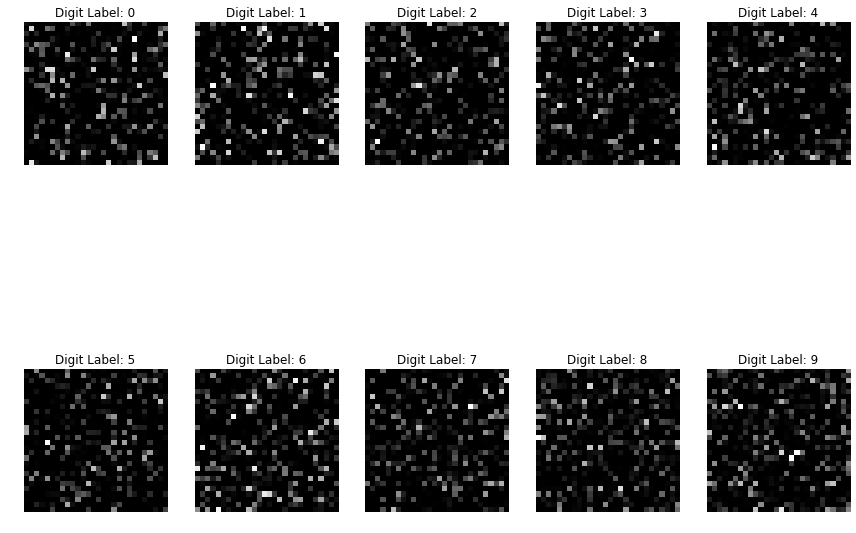

In [65]:
h2_sum = []

for dig in range(10):
    idxs = np.where(y_train == dig)[0]
    rand_idxs = np.random.choice(idxs, 100)

    h2_sum.append(sess.run(h_2, feed_dict={x: x_train_scaled[rand_idxs],
                                           y_true: y_train_oh[rand_idxs],
                                           keep_prob: 1.}
                          ).sum(0).reshape(28,28)
                   )
h2_sum = np.array(h2_sum)

# normalize to [0,1]
for i in range(10):
    h2_sum[i] = h2_sum[i] / np.amax(h2_sum[i])
    
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12,12))

for i, ax in enumerate(axs.reshape(-1)):
    ax.set_title("Digit Label: %d" % i)
    ax.imshow(h2_sum[i], cmap=plt.cm.gray, 
              origin='upper', interpolation='nearest')
    ax.axis('off')
# tight_layout gives more spacing between subplots    
plt.tight_layout()   
# Tell matplotlib to draw all of the previously generated objects
plt.show()

Again, there are clearly differences, but it is difficult to recognize any order.

In [66]:
sess.close()

## Convolutional Deep Network

In this section, we'll build a network with convolutional and pooling layers, closely resembling the one in the Deep MNIST example from the TF tutorial.

Recall that in a fully-connected hidden layer, the new features are computed from the previous layer using a complete weight matrix:
$$ \mathbf{f}^{(i)} = g^{(i)}\left(\mathbf{f}^{(i-1)} \mathbf{W}^{(i)} + \mathbf{b}^{(i)}\right).$$
This structure followed as the most general one possible, but we can try to impose certain conditions:

1. We can force some of the weights  $\mathbf{W}^{(i)}_{a_{i-1}a_i}$ to zero.  This is precisely part of the procedure carried out in the dropout regularization we described earlier.  This generally results in fully-connected models with a smaller capacity.
2. We can impose some symmetry on the weights $\mathbf{W}^{(i)}_{a_{i-1}a_i}$.  This will force some components to be equal to one another.
3. We can remove some connections to the previous layer. This is equivalent to replacing 
$$ \mathbf{f}^{(i-1)} \mathbf{W}^{(i)} \rightarrow \sum_{a_{i-1} \in D} \mathbf{f}^{(i-1)}_{a_{i-1}} \mathbf{W}^{(i)}_{a_{i-1}a_i},$$
where $D$ is some subset of the index set for the incoming features $\mathbf{f}^{(i-1)}$. 

An example of part of a semi-connected network obtained by the condition (3) might be:

![semi-connected network layers](semiconnect.png)

Convolutional layers generally implement the conditions (2) and (3) in a specific way that is tailored to image input data.  In order to understand how these conditions work and how they might improve image recognition, let's take another look at our digit data.

Let's pick out random sets of 6s, 8s, and 9s from the training data:

In [67]:
sixes_idx = np.random.choice(train_df[train_df['label']==6].index, size=4, replace=False)
eights_idx = np.random.choice(train_df[train_df['label']==8].index, size=4, replace=False)
nines_idx = np.random.choice(train_df[train_df['label']==9].index, size=4, replace=False)

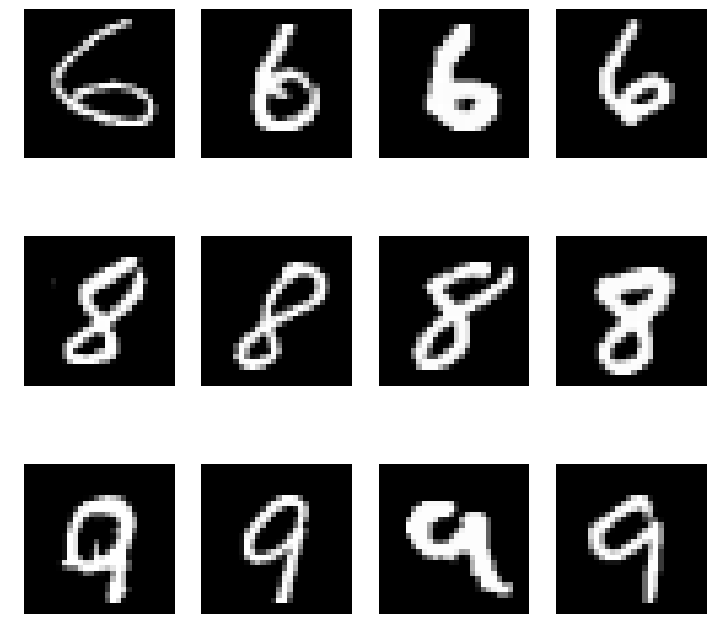

In [68]:
# generate a 3x4 grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,10))

# each row will be 6s, 8s, or 9s
i = 0
for ax in axs[0,:]:
    ax.imshow(pixel_mat(sixes_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[1,:]:
    ax.imshow(pixel_mat(eights_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[2,:]:
    ax.imshow(pixel_mat(nines_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')    
plt.tight_layout()   
plt.show()

Let's imagine looking at these images through a window of the pixels in the upper half of the image.

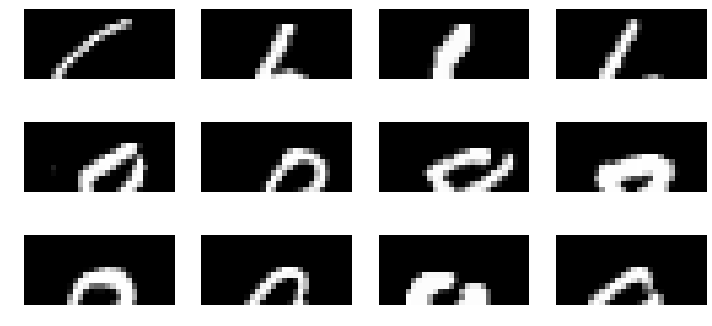

In [69]:
# recover the upper 14x28 block from the 28x28 matrix 
def upper_pixel_mat(row):
    # we're working with train_df so we want to drop the label column
    vec = train_df.drop('label', axis=1).iloc[row].values
    # numpy provides the reshape() function to reorganize arrays into specified shapes
    pixel_mat = vec.reshape(28,28)
    upper_pixel_mat = pixel_mat[0:13,:]
    return upper_pixel_mat


fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,5))

i = 0
for ax in axs[0,:]:
    ax.imshow(upper_pixel_mat(sixes_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[1,:]:
    ax.imshow(upper_pixel_mat(eights_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[2,:]:
    ax.imshow(upper_pixel_mat(nines_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')    
plt.tight_layout()   
plt.show()

Similarly look through a window in the lower half:

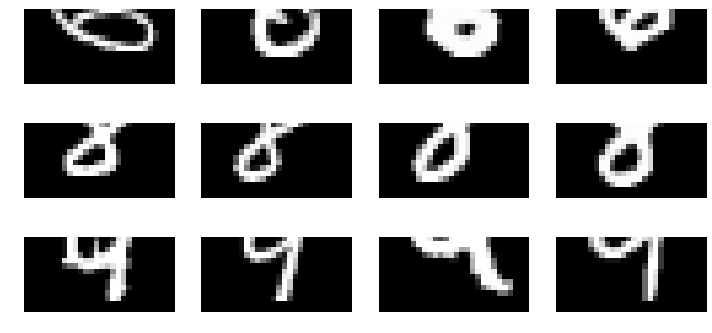

In [70]:
# recover the lower 14x28 block from the 28x28 matrix 
def lower_pixel_mat(row):
    # we're working with train_df so we want to drop the label column
    vec = train_df.drop('label', axis=1).iloc[row].values
    # numpy provides the reshape() function to reorganize arrays into specified shapes
    pixel_mat = vec.reshape(28,28)
    lower_pixel_mat = pixel_mat[14:28,:]
    return lower_pixel_mat


fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(10,5))

i = 0
for ax in axs[0,:]:
    ax.imshow(lower_pixel_mat(sixes_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[1,:]:
    ax.imshow(lower_pixel_mat(eights_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')
i = 0
for ax in axs[2,:]:
    ax.imshow(lower_pixel_mat(nines_idx[i]), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
    i += 1
    ax.axis('off')    
plt.tight_layout()   
plt.show()

We can imagine training an early layer of our network to recognize a closed loop, then a later layer could learn the table:

| loop in upper window | loop in lower window | digit     |
|----------------------|----------------------|-----------|
|         0            |         0            | not 6,8,9 |
|         1            |         0            |      9    |
|         0            |         1            |      6    |
|         1            |         1            |      8    |

A sketch of a convolutional layer being fed into a regular feedforward layer might look like:

![convolutional layer into feedforward layer](convolution1.png)

It is not to hard to guess that the convolutional network will have the hyperparameters:

1. The shape [width, height] of the window employed to sample groups of pixels.  The window is also referred to as the **filter**.

2. The number of pixels in each direction to move the window between samplings.  This is called the **stride**.

3. The number of features to compute per sampling.  This is referred to as the **depth**. If depth > 1, then the filter is actually a tensor of shape [width, height, depth].

In our design matrix, the pixel data has been unrolled and the proximity of pixels in the vertical direction has been obscured.  A convolutional filter is designed to sample over nearby pixels and restore information about the local relationships between the features.

Convolutional layers tend to learn geometric shapes.  In the case of the digits, depending on the filter size, these might look like the highlighted shapes:

![convolutional features](convfeat.png)

Because using the filter is equivalent to sharing weights,  the convolutional layer learns these features wherever they might be found in the image.  The **parameter sharing** introduces a degree of **translational invariance** to the learning algorithm.  Because of the stride, we also retain information in the computed features about where in a particular image a feature is found.   We learn a set of important features that might be present in many types of digits, then the appearance and location in a particular digit helps the network classify that digit.

### Pooling

We have seen that many of the handwritten digits do contain many features in common, but they tend to be slightly displaced from digit to digit. As an example, consider these 4s:

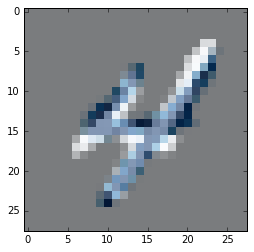

In [71]:
plt.figure(1)
plt.imshow(pixel_mat(9), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
plt.imshow(pixel_mat(59943)-1, cmap=plt.cm.Blues, origin='upper', interpolation='nearest', alpha=0.5)
   
plt.show()

In addition to convolution with a stride, another way of introducing more translational invariance to the model is to use **pooling**.  A pooling layer replaces the inputs of nearby points with an output corresponding to an aggregation of the nearby inputs.  In this notebook, we'll be using **max pooling**, which replaces the inputs with the maximum input found in a rectangular neighborhood.  A cartoon version might look like:

![2x2 max pooling](maxpool.png)

Pooling tends to make a model focus on the most prominent features, regardless of their precise location.

We have only briefly touched on the explanation and utility of convolution and pooling. The interested reader is encouraged to learn more details at, e.g., https://www.deeplearningbook.org


Let us use TensorFlow to put a network together that uses convolutional, pooling and conventional feedforward layers. This will be our first example of a **deep network**.

In [72]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

# set random seed
tf.set_random_seed(464)

The network will have the same input and output layers as before.

In [73]:
n_feat = 784
x = tf.placeholder(tf.float32, shape=[None, n_feat])
n_class = 10
y_true = tf.placeholder(tf.int32, shape=[None, n_class])

Our first layer will be 2d convolutional from the TF op tf.nn.conv2d.  Instead of taking a normal design matrix, this op takes an input which is a tensor of shape [batch, in_height, in_width, in_channels], where: 

* `batch` is the number of observations in the data. 
* `(in_height, in_width)` are the pixel dimensions of the input images.  In our case these are both = 28. 
* `in_channels` is the number of color channels in the input.  Since our images are greyscale, this is just = 1.

Therefore, to apply the first convolutional layer, we need to reshape our input as follows:

In [74]:
x_image = tf.reshape(x, [-1,28,28,1])

The layer also applies a filter/kernel of shape [filter_height, filter_width, in_channels, out_channels], where:

* `(filter_height, filter_width)` are the pixel dimensions of the window. 
* `in_channels` is again the # of color channels in the input.  
* `out_channels` is the number of features for the layer to output. 

In detail, the layer 

1. Samples patches of the image to form a tensor X of shape [batch, out_height, out_width, filter_height $*$ filter_width $*$ in_channels]. 
2. Flattens the filter into a tensor W of shape [filter_height $*$ filter_width $*$ in_channels, output_channels].
3. Computes the matrix product  X.W, which is a tensor of shape [batch, out_height, out_width, output_channels].

We specify the filter by defining a weight tensor of the appropriate shape.  For a 5x5 window, the weights will have shape [5, 5, 1, n_features_out], where n_features_out is the number of features we want the CNN layer to compute. We will compute 4 features in this first layer. 

We also have to decide the stride for the layer,  which is the amount we shift the window between samplings. We specify the stride using a vector containing the information [batch, horizontal_stride, vertical_stride, in_channels]. Stride is constrained to sample one batch input and one input channel at a time, so the stride vector must be given in the form [1, horizontal_stride, vertical_stride, 1]. If we just shift the window by one pixel in either direction for samplings, the stride tensor should be [1, 1, 1, 1].

If we were to just sample 5x5  windows on a 28x28 pixel image, the output would be a 24x24 image. Further CNN and pooling layers would shrink this down even further to the point where we can't apply CNN anymore.  The solution to this is to pad the image with blank pixels in the output to, in our case, keep the output as a 28x28 image, no matter what other transformation we apply to it.  The layers take an argument to specify the type of padding, if any, that we want to apply.

Finally we apply the rectified linear unit as an activation function for this layer.

Putting all of this together, the layer we want is specified by:

In [75]:
n_convfeat1 = 4

W_conv1 = weight_variable([5, 5, 1, n_convfeat1])
b_conv1 = bias_variable([n_convfeat1])

CNN1 = tf.nn.conv2d(x_image, W_conv1, strides=[1, 1, 1, 1], padding='SAME')
h_conv1 = tf.nn.relu(tf.add(CNN1, b_conv1))

In [76]:
h_conv1

<tf.Tensor 'Relu:0' shape=(?, 28, 28, 4) dtype=float32>

As promised, the output of this layer is a 28x28 "image" with 32 features per pixel. 

The next layer will be a pooling layer.  We will follow the tutorial and use max pooling via the op tf.nn.max_pool. Max pooling reports the maximum output for a given feature in a specified area, which this op expects to be a rectangle.   More specifically, the input has shape
[batch, height, width, channels] and the window is also specified according to these dimensions. 

We want to max pool over 2x2 windows, so we must specify the shape list [1, 2, 2, 1].   This samples once per input image and feature, but performs max pooling over the 2x2 geometric window.   Furthermore, we don't want our windows to overlap (that would not introduce enough translational invariance), so to shift by 2 pixels we specify the stride [1, 2, 2, 1].

Padding with the pooling op works differently from padding with the CNN ops.  Here we add padding if BEFORE the pooling transformation if it is necessary to carry out the specified pooling operation.  For instance, if we wanted to do 2x2 pooling with a stride of 2 on a 3x3 image, we would need to pad the image to 4x4.  Our output would be 2x2.

We specify this pooling layer via:

In [77]:
h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1], 
                         strides=[1, 2, 2, 1], padding='SAME')

In [78]:
h_pool1

<tf.Tensor 'MaxPool:0' shape=(?, 14, 14, 4) dtype=float32>

This is a 14x14 image with the same 4 features outputted by the CNN.  

Again following the tutorial, we wish to introduce additional CNN and pooling layers.  We will again choose the CNN to be 5x5 with unit stride and apply another instance of 2x2 max pooling with stride 2.  The output will be a 7x7 image. Note that the output of the first pooling layer had $14*14*4 = 784$ features per image. This is precisely equal to the number of input features.  In order to retain this information after the 2nd pooling layer, we should compute $784/(7*7) = 16$ features in the 2nd convolutional layer.

In [79]:
n_convfeat2 = 16

W_conv2 = weight_variable([5, 5, n_convfeat1, n_convfeat2])
b_conv2 = bias_variable([n_convfeat2])

CNN2 = tf.nn.conv2d(h_pool1, W_conv2, strides=[1, 1, 1, 1], padding='SAME')
h_conv2 = tf.nn.relu(tf.add(CNN2, b_conv2))

h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1], 
                         strides=[1, 2, 2, 1], padding='SAME')
h_pool2

<tf.Tensor 'MaxPool_1:0' shape=(?, 7, 7, 16) dtype=float32>

Our fully connected single layer NN was working pretty well so we will include one as the next layer. We have 784 total features coming in, so we might expect a layer of a similar width will give the best results.  We'll choose a width of 784, as in our earlier single layer NN.  We will flatten the 7x7 image into a pixel vector to make the computations more convenient.

In [80]:
width1 = 784

W_1 = weight_variable([7 * 7 * n_convfeat2, width1])
b_1 = bias_variable([width1])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*n_convfeat2])

h_1 = tf.nn.relu(tf.add(tf.matmul(h_pool2_flat, W_1), b_1))

As before,  we'll introduce a dropout layer.

In [81]:
keep_prob = tf.placeholder(tf.float32)
h_1_drop = tf.nn.dropout(h_1, keep_prob)

And output layer.

In [82]:
W_out = weight_variable([width1, n_class])
b_out = bias_variable([n_class])

z_out = tf.add(tf.matmul(h_1_drop, W_out), b_out)

The cost, metric and optimizer choices will also be the same.

In [83]:
cost = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
                        labels=y_true, logits=z_out))
corr = tf.equal(tf.argmax(z_out, 1), tf.argmax(y_true, 1))    
accr = tf.reduce_mean(tf.cast(corr, "float"))

learning_rate = 0.0001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

The convolutional layers can be quite memory intensive, since we are computing some number of features for each pixel in the original image.  To ensure that we can run in around 8 GB of memory, in addition to the minibatch training, we will also compute the accuracy metrics in minibatches. 

In [84]:
n_batch = 50.
int_batch = int(n_batch)

n_samp_train = x_train_scaled.shape[0]
n_samp_test = x_test_scaled.shape[0]

train_batch = int(n_samp_train / n_batch)
test_batch = int(n_samp_test / n_batch)

skfold = StratifiedKFold(n_splits=train_batch, shuffle=True, random_state=428)

In [85]:
# Number of epochs to train over.
n_epoch = 100 + 1

# Compute appropriate metrics at checkpoints
display_step = 10

# initialize variables
sess.run(tf.global_variables_initializer())

start = time()
for epoch in range(n_epoch):
    # init average cost 
    avg_cost = 0.
    
    for dummy_idx, batch_idx in skfold.split(x_train_scaled, y_train):
        x_batch, y_batch = x_train_scaled[batch_idx], y_train_oh[batch_idx]
        _, c = sess.run([optimizer, cost], 
                        feed_dict={x: x_batch, 
                                   y_true: y_batch, 
                                   keep_prob: 0.5})
        # Compute average cost
        avg_cost += c / train_batch
        
    # Display logs per epoch step
    if epoch % display_step == 0:
        # return epoch and average cost
        print("Epoch: %.4d" % epoch, "cost = %.4f" % avg_cost, 
              "time = %.2f" % (time() - start))
        # compute accuracy on full training set, in batches
        train_acc = 0
        for i in range(0, n_samp_train, int_batch):
            x_batch, y_batch = x_train_scaled[i:i + int_batch], \
                                y_train_oh[i:i + int_batch]
            acc = sess.run(accr,
                            feed_dict={x: x_batch,
                                       y_true: y_batch, 
                                       keep_prob: 1.})
            train_acc += acc / train_batch
        print ("TRAIN ACCURACY: %.4f" % (train_acc))
        # compute accuracy on full validation set, in batches
        test_acc = 0
        for i in range(0, n_samp_test, int_batch):
            x_batch, y_batch = x_test_scaled[i:i + int_batch], \
                                y_test_oh[i:i + int_batch]
            acc = sess.run(accr,
                            feed_dict={x: x_batch,
                                       y_true: y_batch, 
                                       keep_prob: 1.})
            test_acc += acc / test_batch
        print ("TEST ACCURACY: %.4f" % (test_acc))

# After the full training cycle, return more logs
# compute accuracy on full training set, in batches
train_acc = 0
for i in range(0, n_samp_train, int_batch):
    x_batch, y_batch = x_train_scaled[i:i + int_batch], \
                        y_train_oh[i:i + int_batch]
    acc = sess.run(accr,
                    feed_dict={x: x_batch,
                               y_true: y_batch, 
                               keep_prob: 1.})
    train_acc += acc / train_batch
# compute accuracy on full validation set, in batches
test_acc = 0
for i in range(0, n_samp_test, int_batch):
    x_batch, y_batch = x_test_scaled[i:i + int_batch], \
                        y_test_oh[i:i + int_batch]
    acc = sess.run(accr,
                    feed_dict={x: x_batch,
                               y_true: y_batch, 
                               keep_prob: 1.})
    test_acc += acc / test_batch
    
print("Optimization finished in %.2f seconds!" % (time() - start)) 
print("For n_convfeat1 = %d, n_convfeat2 = %d, width1 = %d, n_epoch = %d," \
      % (n_convfeat1, n_convfeat2, width1, n_epoch))
print ("TRAIN ACCURACY: %.4f" % (train_acc))
print ("TEST ACCURACY: %.4f" % (test_acc))   

('Epoch: 0000', 'cost = 0.6797', 'time = 38.61')
TRAIN ACCURACY: 0.9484
TEST ACCURACY: 0.9502
('Epoch: 0010', 'cost = 0.0485', 'time = 430.76')
TRAIN ACCURACY: 0.9911
TEST ACCURACY: 0.9869
('Epoch: 0020', 'cost = 0.0245', 'time = 823.77')
TRAIN ACCURACY: 0.9959
TEST ACCURACY: 0.9905
('Epoch: 0030', 'cost = 0.0139', 'time = 1219.23')
TRAIN ACCURACY: 0.9984
TEST ACCURACY: 0.9921
('Epoch: 0040', 'cost = 0.0092', 'time = 1613.14')
TRAIN ACCURACY: 0.9990
TEST ACCURACY: 0.9919
('Epoch: 0050', 'cost = 0.0065', 'time = 2002.87')
TRAIN ACCURACY: 0.9996
TEST ACCURACY: 0.9923
('Epoch: 0060', 'cost = 0.0042', 'time = 2395.38')
TRAIN ACCURACY: 0.9998
TEST ACCURACY: 0.9923
('Epoch: 0070', 'cost = 0.0036', 'time = 2796.62')
TRAIN ACCURACY: 0.9999
TEST ACCURACY: 0.9929
('Epoch: 0080', 'cost = 0.0024', 'time = 3190.48')
TRAIN ACCURACY: 0.9999
TEST ACCURACY: 0.9933
('Epoch: 0090', 'cost = 0.0020', 'time = 3587.97')
TRAIN ACCURACY: 0.9999
TEST ACCURACY: 0.9922
('Epoch: 0100', 'cost = 0.0021', 'time = 398

Each epoch of deep and backprop training is taking around 30s, which is 2x that of the two layer model and 4x that of the single layer model. Total training time is about one hour. At 99.3% accuracy, this is our best model so far.  

Finally, we'll note that a model with far more features:

```
Optimization finished in 37388.73 seconds!
For n_convfeat1 = 32, n_convfeat2 = 128, width1 = 3072, n_epoch = 150,
TRAIN ACCURACY: 1.000
TEST ACCURACY: 0.992
```

took around 10 hours to train and had worse performance.  It is possible that this was due to overfitting.

We can save the class probabilities:

In [86]:
class_prob_cnn = sess.run(tf.nn.softmax(z_out), 
                           feed_dict={x: x_test_scaled, y_true: y_test_oh, keep_prob: 1.})

We can also look at the features output by each convolutional layer.

In [87]:
# get all indices from y_train where the label is 2
twos_idx = np.where(y_train == 2)[0]

# pick 10 entries at random
rand_twos_idx = np.random.choice(twos_idx, 5)

# corresponding design matrix from scaled features
x_train_twos = x_train_scaled[rand_twos_idx]
y_train_twos = y_train_oh[rand_twos_idx]

h1_train_twos = sess.run(h_conv1, feed_dict={x: x_train_twos, 
                                         y_true: y_train_twos,
                                         keep_prob: 1.})

h_pool1_train_twos = sess.run(h_pool1, feed_dict={x: x_train_twos, 
                                         y_true: y_train_twos,
                                         keep_prob: 1.})


h2_train_twos = sess.run(h_conv2, feed_dict={x: x_train_twos, 
                                         y_true: y_train_twos,
                                         keep_prob: 1.})

These are plots of the original image, compared to the features output by the 1st convolutional layer.

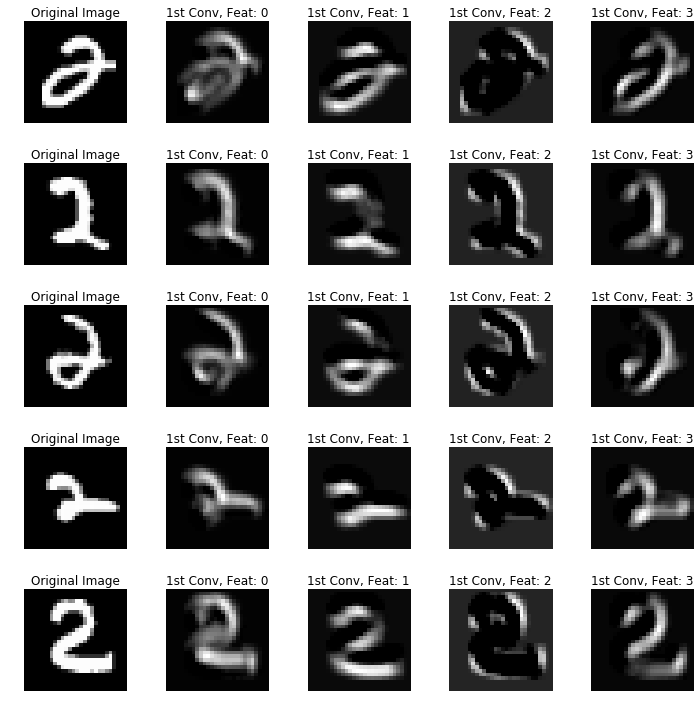

In [88]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))

orig_set = set(range(0,25,5))
feat0_set = set(range(1,25,5))
feat1_set = set(range(2,25,5))
feat2_set = set(range(3,25,5))
feat3_set = set(range(4,25,5))

for i, ax in enumerate(axs.reshape(-1)):
    if (i in orig_set):   # these are the original features
        pixel_mat_in = x_train_twos[i/5].reshape(28,28)
        ax.imshow(pixel_mat_in, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("Original Image")
        ax.axis('off')
    if (i in feat0_set):   # next are the 1st conv layer features
        pixel_mat_h1_f0 = h1_train_twos[(i-1)/5,:,:,0].reshape(28,28)
        ax.imshow(pixel_mat_h1_f0, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("1st Conv, Feat: 0")
        ax.axis('off')
    if (i in feat1_set):   # next are the 1st conv layer features
        pixel_mat_h1_f1 = h1_train_twos[(i-1)/5,:,:,1].reshape(28,28)
        ax.imshow(pixel_mat_h1_f1, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("1st Conv, Feat: 1")
        ax.axis('off')
    if (i in feat2_set):   # next are the 1st conv layer features
        pixel_mat_h1_f2 = h1_train_twos[(i-1)/5,:,:,2].reshape(28,28)
        ax.imshow(pixel_mat_h1_f2, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("1st Conv, Feat: 2")
        ax.axis('off')
    if (i in feat3_set):   # next are the 1st conv layer features
        pixel_mat_h1_f3 = h1_train_twos[(i-1)/5,:,:,3].reshape(28,28)
        ax.imshow(pixel_mat_h1_f3, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("1st Conv, Feat: 3")
        ax.axis('off')
# tight_layout gives more spacing between subplots    
plt.tight_layout()   
# Tell matplotlib to draw all of the previously generated objects
plt.show()

These are plots of the 0th feature output by the 1st pooling layer, followed by the first 4 features output by the 2nd convolutional layer.

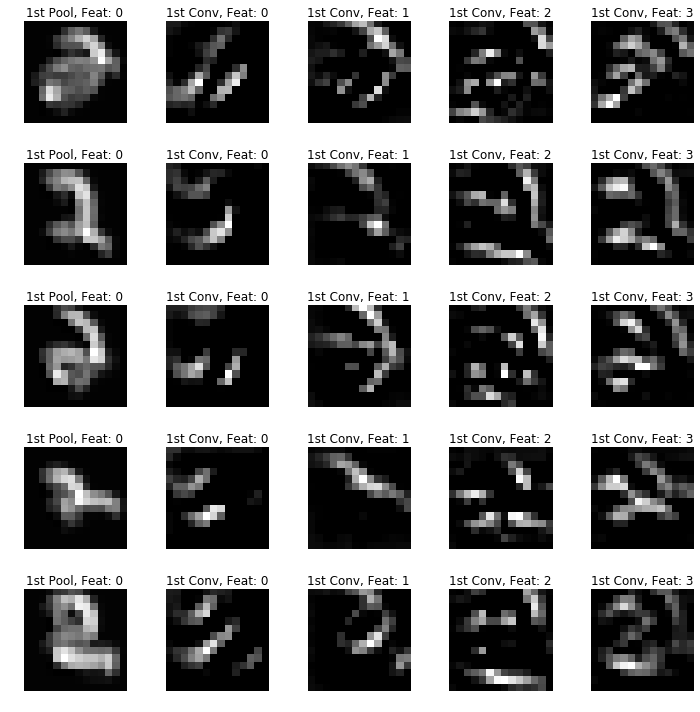

In [89]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10,10))

orig_set = set(range(0,25,5))
feat0_set = set(range(1,25,5))
feat1_set = set(range(2,25,5))
feat2_set = set(range(3,25,5))
feat3_set = set(range(4,25,5))

for i, ax in enumerate(axs.reshape(-1)):
    if (i in orig_set):   # these are the original features
        pixel_mat_in = h_pool1_train_twos[i/5,:,:,0]
        ax.imshow(pixel_mat_in, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("1st Pool, Feat: 0")
        ax.axis('off')
    if (i in feat0_set):   # next are the 1st conv layer features
        pixel_mat_h2_f0 = h2_train_twos[(i-1)/5,:,:,0]
        ax.imshow(pixel_mat_h2_f0, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("1st Conv, Feat: 0")
        ax.axis('off')
    if (i in feat1_set):   # next are the 1st conv layer features
        pixel_mat_h2_f1 = h2_train_twos[(i-1)/5,:,:,1]
        ax.imshow(pixel_mat_h2_f1, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("1st Conv, Feat: 1")
        ax.axis('off')
    if (i in feat2_set):   # next are the 1st conv layer features
        pixel_mat_h2_f2 = h2_train_twos[(i-1)/5,:,:,2]
        ax.imshow(pixel_mat_h2_f2, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("1st Conv, Feat: 2")
        ax.axis('off')
    if (i in feat3_set):   # next are the 1st conv layer features
        pixel_mat_h2_f3 = h2_train_twos[(i-1)/5,:,:,3]
        ax.imshow(pixel_mat_h2_f3, cmap=plt.cm.gray, 
                  origin='upper', interpolation='nearest')
        ax.set_title("1st Conv, Feat: 3")
        ax.axis('off')
# tight_layout gives more spacing between subplots    
plt.tight_layout()   
# Tell matplotlib to draw all of the previously generated objects
plt.show()

Compared to the fully-connected layers, it is clear that these features inherit geometric properties from the original image.

In [90]:
sess.close()

### Analysis of Errors

It might be useful to take a closer look at the examples in the validation set where our CNN got the wrong answer. 

First, lets check a random sample of the class probabilites:

In [91]:
idxs = np.random.randint(0, len(class_prob_cnn), 5)
class_prob_cnn[idxs]

array([[  1.25094028e-31,   2.54768920e-18,   2.73141132e-29,
          6.02086613e-22,   1.00000000e+00,   6.45046372e-28,
          6.67888928e-24,   3.44917819e-23,   1.13713079e-25,
          3.81366426e-19],
       [  1.19201474e-28,   1.29359824e-29,   5.16752960e-23,
          1.53186771e-21,   6.98138602e-10,   2.18912836e-17,
          8.35600527e-33,   1.46896872e-13,   3.02901948e-21,
          1.00000000e+00],
       [  2.72273736e-20,   4.85907625e-12,   1.00000000e+00,
          1.63087327e-17,   4.00144537e-19,   1.15472966e-25,
          9.56217825e-24,   3.40829032e-09,   1.71010493e-18,
          2.15014768e-24],
       [  2.52503018e-10,   1.55257196e-11,   4.88595233e-16,
          5.40501278e-18,   2.62677412e-13,   2.00350825e-09,
          1.00000000e+00,   1.79617746e-19,   2.96631963e-08,
          2.61638816e-17],
       [  3.69550218e-17,   1.73554293e-09,   6.89907997e-09,
          8.15916779e-11,   4.48197955e-15,   2.68144570e-20,
          6.53838110e-22

We can use argmax to compute the most probable prediction for each example:

In [92]:
y_pred_cnn = np.argmax(class_prob_cnn, 1)
y_pred_cnn

array([7, 2, 1, ..., 4, 5, 6])

These are to be compared with the list of true labels from y_validation, which we can reobtain by also applying argmax:

In [93]:
y_act = np.argmax(y_test_oh, 1)
y_act

array([7, 2, 1, ..., 4, 5, 6])

Another useful numpy function is argsort, which returns the indices that would sort an array, from smallest element to largest. In our case, it is more convenient to sort from largest to smallest, in which case we can specify np.argsort(-vec). In the case of our class probability vectors, the first entry in argsort(-vec) will be the argmax, while the next will be the 2nd most probable class, then the 3rd and so on.  It can be useful to know if the true label was given a relatively high probability if the most probable model class was incorrect. For example, we can consider

In [94]:
print(class_prob_cnn[idxs])
print(np.argsort(-class_prob_cnn[idxs]))
print(np.argmax(class_prob_cnn[idxs], 1))

[[  1.25094028e-31   2.54768920e-18   2.73141132e-29   6.02086613e-22
    1.00000000e+00   6.45046372e-28   6.67888928e-24   3.44917819e-23
    1.13713079e-25   3.81366426e-19]
 [  1.19201474e-28   1.29359824e-29   5.16752960e-23   1.53186771e-21
    6.98138602e-10   2.18912836e-17   8.35600527e-33   1.46896872e-13
    3.02901948e-21   1.00000000e+00]
 [  2.72273736e-20   4.85907625e-12   1.00000000e+00   1.63087327e-17
    4.00144537e-19   1.15472966e-25   9.56217825e-24   3.40829032e-09
    1.71010493e-18   2.15014768e-24]
 [  2.52503018e-10   1.55257196e-11   4.88595233e-16   5.40501278e-18
    2.62677412e-13   2.00350825e-09   1.00000000e+00   1.79617746e-19
    2.96631963e-08   2.61638816e-17]
 [  3.69550218e-17   1.73554293e-09   6.89907997e-09   8.15916779e-11
    4.48197955e-15   2.68144570e-20   6.53838110e-22   1.00000000e+00
    1.30658633e-15   4.75209802e-11]]
[[4 1 9 3 7 6 8 5 2 0]
 [9 4 7 5 8 3 2 0 1 6]
 [2 7 1 3 8 4 0 6 9 5]
 [6 8 5 0 1 4 2 9 3 7]
 [7 2 1 3 9 4 8 0 5 6]

It is also interesting to look at the confusion matrix:

In [95]:
from sklearn.metrics import confusion_matrix

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

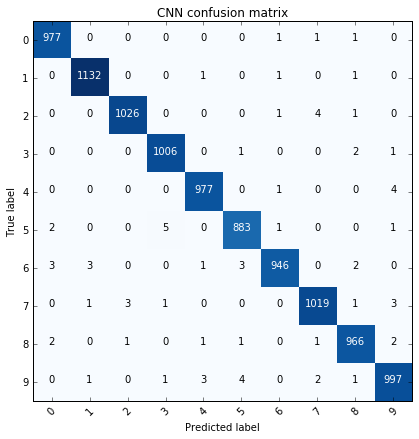

In [96]:
conf_mat = confusion_matrix(y_act, y_pred_cnn)

plt.figure(figsize=(6,6))
plot_confusion_matrix(conf_mat, classes=range(10), title='CNN confusion matrix')
plt.show()

The model does well, as expected from the accuracy score. We will look at all examples where the model was confused and then look at a couple in detail.

In order to compare with the features in the corresponding design matrix, x_validation, we can use the numpy where function to obtainindices for the events where the prediction was different from the true value:

In [97]:
error_idx = np.where(y_pred_cnn != y_act)[0]

In [98]:
error_idx

array([ 115,  340,  445,  582,  646,  684,  924, 1014, 1112, 1181, 1182,
       1226, 1242, 1247, 1260, 1319, 1709, 1901, 2035, 2070, 2109, 2129,
       2130, 2135, 2369, 2387, 2447, 2597, 2648, 2654, 2896, 2939, 2953,
       2995, 3030, 3225, 3422, 3451, 3474, 3520, 3558, 3559, 3727, 3762,
       3808, 4176, 4224, 4238, 4284, 4497, 4536, 4761, 4823, 5654, 5937,
       5955, 5973, 5997, 6555, 6597, 6625, 6783, 7216, 8094, 8376, 9540,
       9634, 9642, 9664, 9729, 9770])

We will plot all errors, ordered by most probable class label:

In [99]:
def plot_digits_bypred(digit):
    # generate a 4xn grid of subplots, 4 is the number of columns that will reasonably display in typical
    # overhead projector resolution at the size we're making the images 
    pred_dig = digit
    pred_dig_idx = error_idx[np.where(y_pred_cnn[error_idx] == pred_dig)[0].tolist()]
    list_len = len(pred_dig_idx)
    ncols = 4
    nrows =  (list_len / 4) + (1 * (list_len % 4 != 0)) # add an extra row if list_len !div by 4
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,10))


    # axs is a 2d array so we flatten it into a vector in order to loop over it
    for i, ax in enumerate(axs.reshape(-1)):
        if i < list_len:   # don't generate ax titles for unused subplots
            # cycle through the elements of rand_idx
            idx = pred_dig_idx[i]
            # this is the true class label
            true_y = y_act[idx]
            # this is the vector of model class probabilities
            prob_y = class_prob_cnn[idx]
            # this is the most probable class
            top_pred = np.argmax(prob_y)
            # this is probability of the top class
            prob_top = prob_y[top_pred]
            # argsort the prob. vector
            arg_sort = np.argsort(-prob_y)
            # this is the 2nd choice class 
            sec_choice = arg_sort[1]
            # this is the probability of the 2nd choice class
            prob_sec = prob_y[sec_choice]
            ax.set_title("True: %d \n Pred: %d (%.2f), %d (%.2f)" % 
                         (true_y, top_pred, prob_top, sec_choice, prob_sec))
            ax.imshow(x_test[idx].reshape(28,28), cmap=plt.cm.gray, origin='upper', interpolation='nearest')
            ax.axis('off')
        if i >= list_len:
            fig.delaxes(ax)
      
    plt.tight_layout()    
    plt.show()

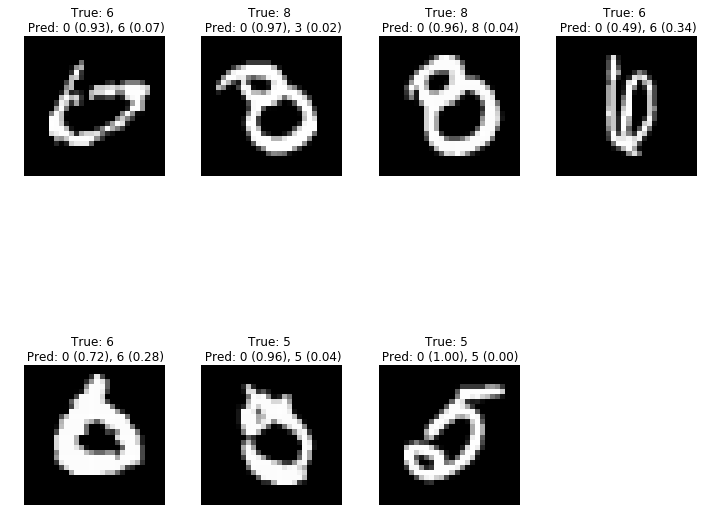

In [100]:
plot_digits_bypred(0)

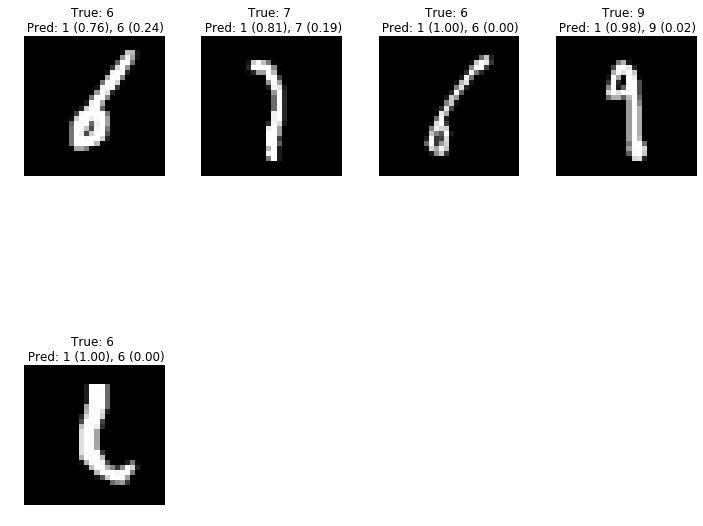

In [101]:
plot_digits_bypred(1)

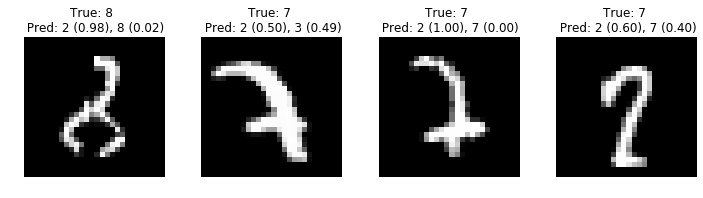

In [102]:
plot_digits_bypred(2)

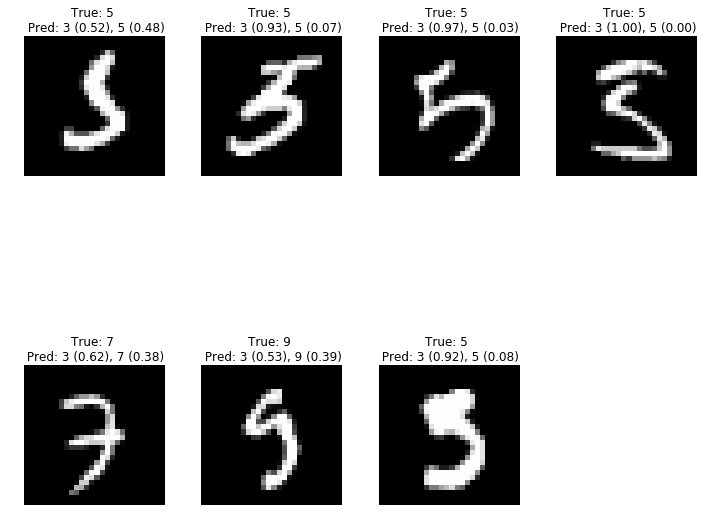

In [103]:
plot_digits_bypred(3)

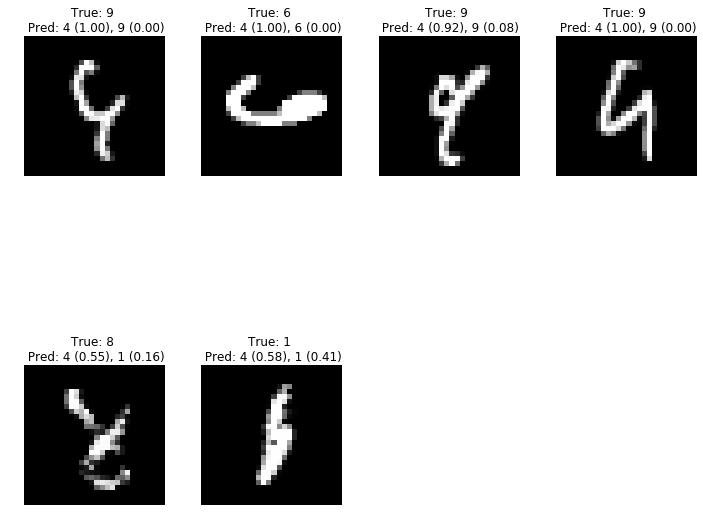

In [104]:
plot_digits_bypred(4)

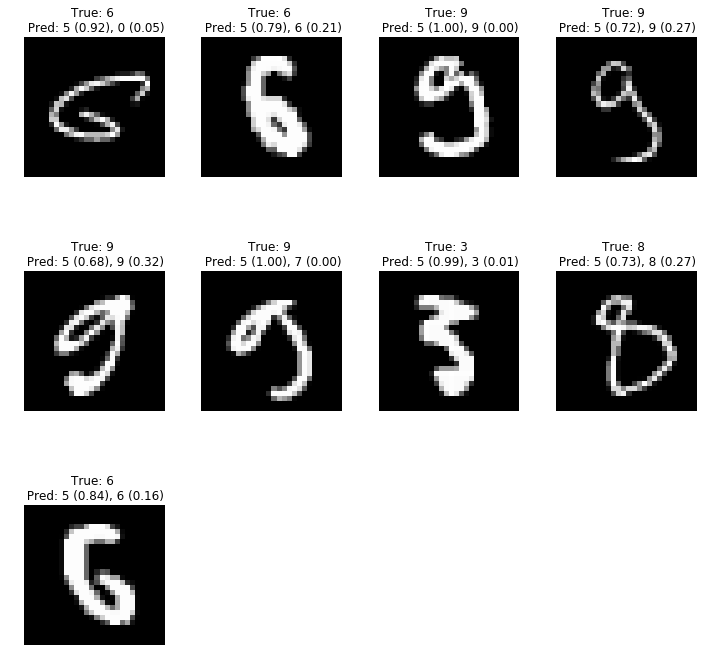

In [105]:
plot_digits_bypred(5)

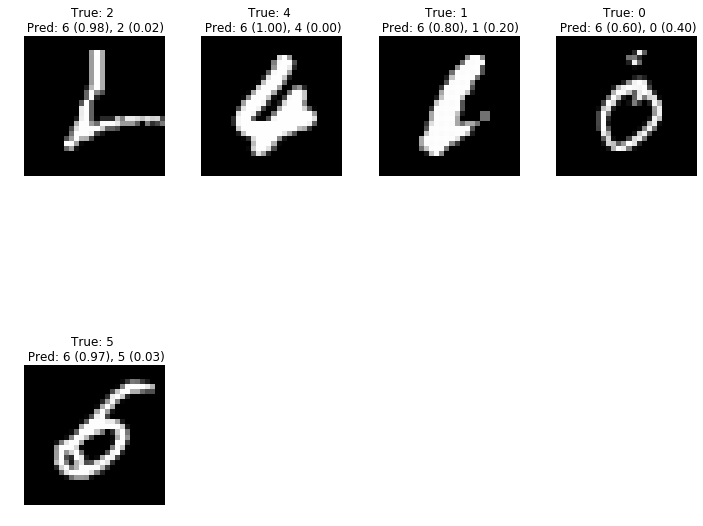

In [106]:
plot_digits_bypred(6)

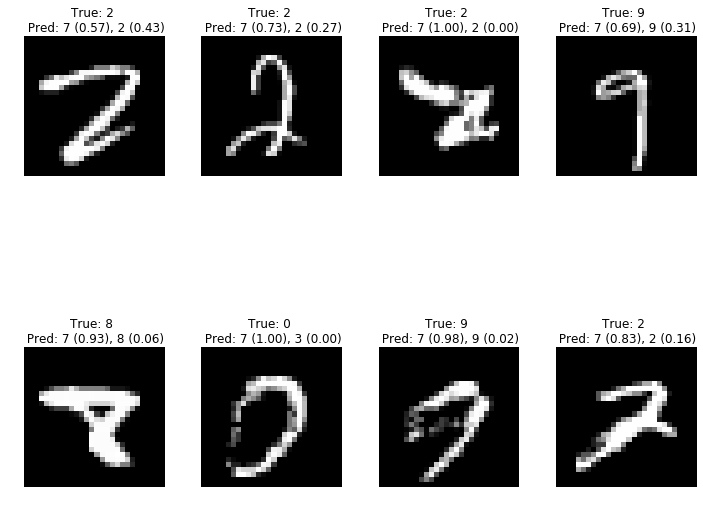

In [107]:
plot_digits_bypred(7)

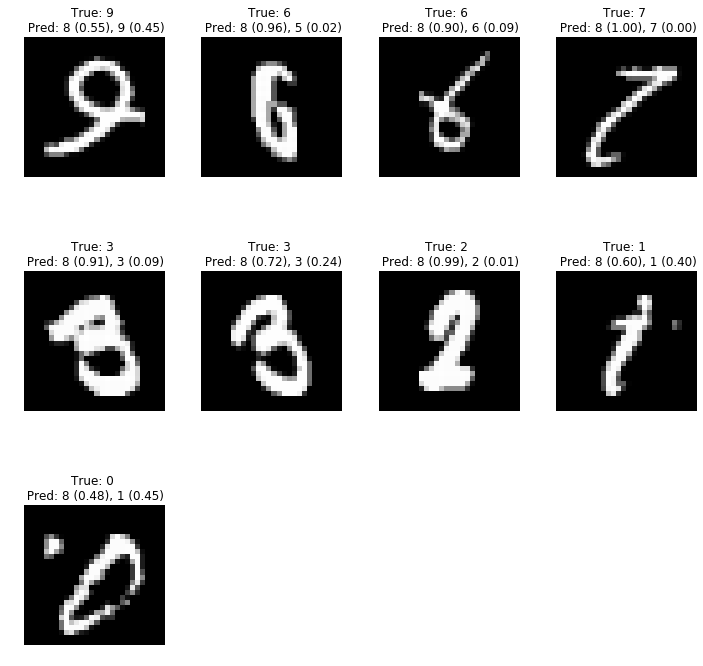

In [108]:
plot_digits_bypred(8)

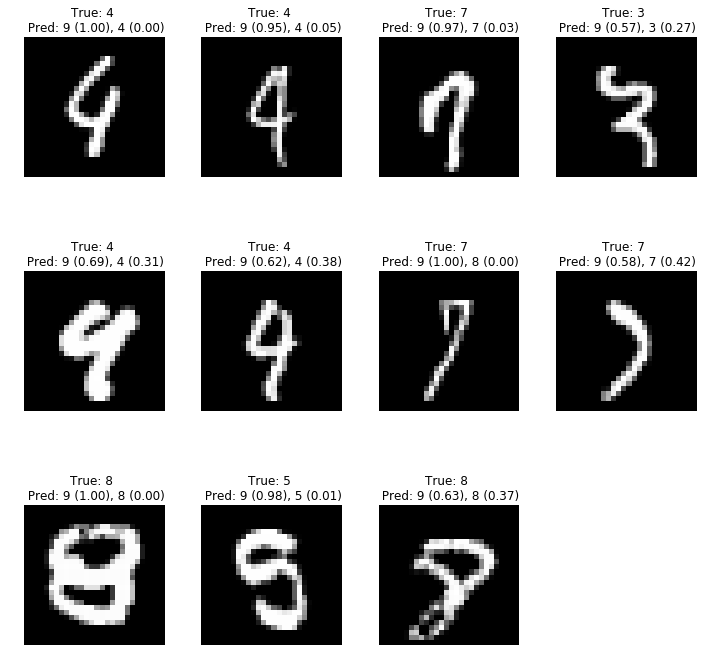

In [109]:
plot_digits_bypred(9)

It is likely that several of these would be challenging for a human to identify with 100% accuracy, while others are quite obvious.   In some cases, it is easy to see what features that the neural network probably used to decide that the image more closely resembled a different digit than the true one.

For instance, for the following digit image, the CNN predicted "3" vs the true value of 5.

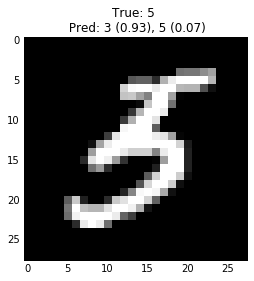

In [110]:
idx = 2035
# this is the true class label
true_y = y_act[idx]
# this is the vector of model class probabilities
prob_y = class_prob_cnn[idx]
# this is the most probable class
top_pred = np.argmax(prob_y)
# this is probability of the top class
prob_top = prob_y[top_pred]
# argsort the prob. vector
arg_sort = np.argsort(-prob_y)
# this is the 2nd choice class 
sec_choice = arg_sort[1]
# this is the probability of the 2nd choice class
prob_sec = prob_y[sec_choice]
    
plt.imshow(x_test[idx].reshape(28,28), cmap=plt.cm.gray, origin='upper', interpolation='nearest') 
plt.title("True: %d \n Pred: %d (%.2f), %d (%.2f)" % 
                 (true_y, top_pred, prob_top, sec_choice, prob_sec))
plt.show()

In this case, a human would probably tend to guess 5, but without complete certainty.  Because of the slant of the 5 to the right, the lower half of the digit looks quite like an upright 3.  The stroke at the top of the digit has enough of a left tail to resemble a 3.  Also the slant of the digit again makes this tail meet at an angle that reproduces a half loop associated with a 3.  The model's 2nd choice was 5, with a probability of 10% assigned.

For the converse identification problem, we can look at the following example:

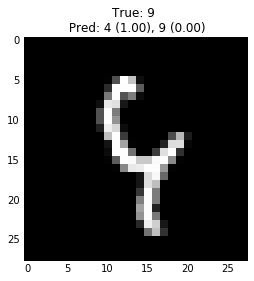

In [111]:
idx = 1901
# this is the true class label
true_y = y_act[idx]
# this is the vector of model class probabilities
prob_y = class_prob_cnn[idx]
# this is the most probable class
top_pred = np.argmax(prob_y)
# this is probability of the top class
prob_top = prob_y[top_pred]
# argsort the prob. vector
arg_sort = np.argsort(-prob_y)
# this is the 2nd choice class 
sec_choice = arg_sort[1]
# this is the probability of the 2nd choice class
prob_sec = prob_y[sec_choice]
    
plt.imshow(x_test[idx].reshape(28,28), cmap=plt.cm.gray, origin='upper', interpolation='nearest') 
plt.title("True: %d \n Pred: %d (%.2f), %d (%.2f)" % 
                 (true_y, top_pred, prob_top, sec_choice, prob_sec))
plt.show()

Here a human might guess 4 fairly often as well.  The loop of the 9 is broken.  The bottom of the loop and the lower stem make a right angle, like most 4s.  

In [112]:
100 * class_prob_cnn[idx]

array([  3.73596110e-16,   3.73015894e-08,   5.05362308e-10,
         5.65691882e-10,   9.99719772e+01,   3.64404507e-10,
         9.10178102e-08,   1.31899185e-08,   1.52751920e-04,
         2.78652292e-02], dtype=float32)

The correct choice of 9 was 2nd with a  0.03% probability, which was far behind the first choice.

## Conclusions

In this notebook, we learned how to use TensorFlow to construct machine learning models using very low-level tools.  TF allows us to define models in much more detail than scikit-learn, but at the cost of requiring quite a bit of expertise about how those models work in theory and are constructed in practice.

We also learned how to apply neural networks, including the multilevel perceptron and convolutional neural networks to the MNIST digit problem.  We saw that they lead to improvements of over 2% in validation accuracy vs our Random Forest result.